# Training Norm-reference encoding on FERG dataset

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf

from utils.load_config import load_config
from utils.load_data import load_data
from utils.extraction_model import load_extraction_model
from utils.patches import pred_to_patch
from utils.patches import get_patches_centers
from utils.patches import max_pool_patches_activity

np.random.seed(0)
np.set_printoptions(precision=3, suppress=True, linewidth=180)

### declare parameters

In [2]:
# define configuration
config_path = 'NR_02_FERG_m0001.json'

# load config
config = load_config(config_path, path='../../configs/norm_reference')

In [3]:
### Load training data
train_data = load_data(config)
print("shape train_data[0]", np.shape(train_data[0]))

100%|██████████| 2000/2000 [00:04<00:00, 478.70it/s]


shape train_data[0] (2000, 224, 224, 3)


In [330]:
def display_image(image, lmks=None, ref_lmks=None, lmk_size=5, pre_processing=None, figure=None, title=None):
    img = np.copy(image)

    if pre_processing == 'VGG19':
        # (un-)process image from VGG19 pre-processing
        img = np.array(img + 128) / 256
        img = img[..., ::-1]  # rgb
        img[img > 1] = 1.0

    # compute padding
    lmk_padding = int(lmk_size/2)

    if ref_lmks is not None:
        # add lmk on image
        ref_lmks = np.array(ref_lmks).astype(int)
        for r_lmk in ref_lmks:
            img[r_lmk[1]-lmk_padding:r_lmk[1]+lmk_padding, r_lmk[0]-lmk_padding:r_lmk[0]+lmk_padding] = [0, 1, 0]

    if lmks is not None:
        # add lmk on image
        lmks = np.array(lmks).astype(int)
        for lmk in lmks:
            img[lmk[1]-lmk_padding:lmk[1]+lmk_padding, lmk[0]-lmk_padding:lmk[0]+lmk_padding] = [0, 1, 1]

    if figure is None:
        plt.figure()
        plt.imshow(img)

        if title is not None:
            plt.title(title)
    else:
        figure.imshow(img)

        if title is not None:
            figure.set_title(title)

In [328]:
def display_images(images, lmks=None, ref_lmks=None, n_max_col=7, size_img=4, lmk_size=5, pre_processing=None, titles=None):
    n_image = len(images)

    # compute n_row and n_column
    n_col = np.min([n_max_col, n_image])
    n_row = int(n_image / n_col)

    # declare figure
    fig, axs = plt.subplots(n_row, n_col)
    fig.set_figheight(n_row*size_img)
    fig.set_figwidth(n_col*size_img)

    lmk_pos = None

    for i in range(n_row):
        for j in range(n_col):
            img_idx = i * n_col + j

            if lmks is not None:
                lmk_pos = lmks[img_idx]

            title=None
            if titles is not None:
                title = titles[img_idx]

            if n_row == 1 and n_col == 1:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, pre_processing=pre_processing, figure=axs, title=title)
            elif n_row == 1:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, pre_processing=pre_processing, figure=axs[img_idx], title=title)
            else:
                display_image(images[img_idx], lmks=lmk_pos, ref_lmks=ref_lmks, lmk_size=lmk_size, pre_processing=pre_processing, figure=axs[i, j], title=title)

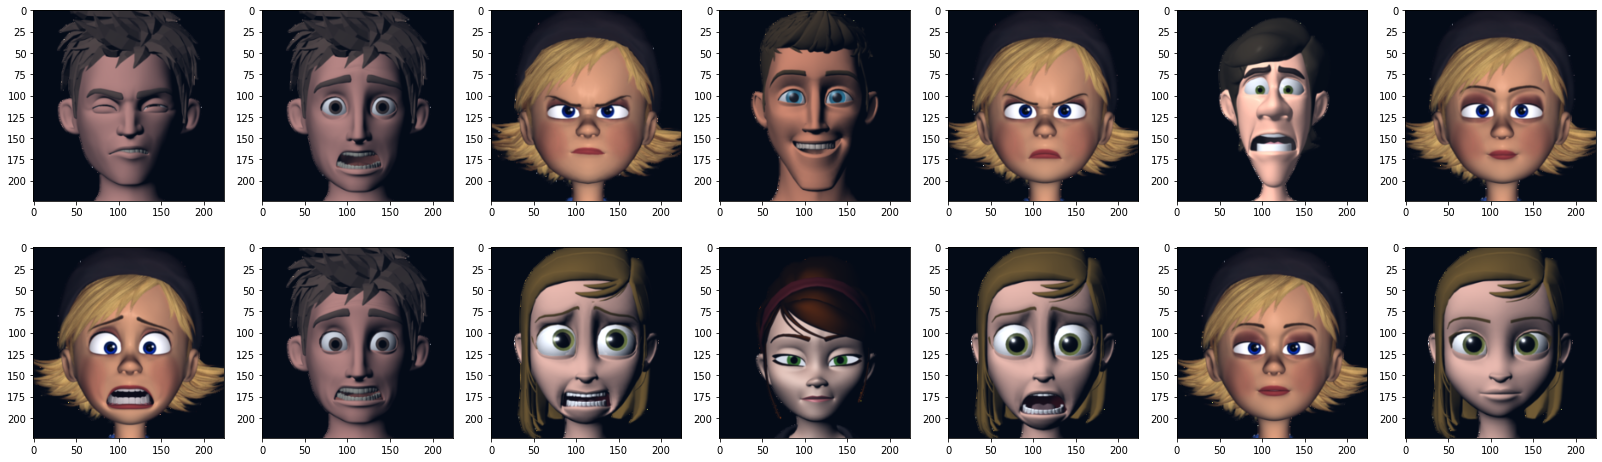

In [6]:
display_images(train_data[0][:14], n_max_col=7, pre_processing='VGG19')

Labeled images

| Avatar  |             Neutral (0) |                   Happy (1) |               Angry (2) |                   Sad (3) |                Surprise (4) |              Fear (5) |            Disgust (6) |
|:--------|------------------------:|----------------------------:|------------------------:|--------------------------:|----------------------------:|----------------------:|-----------------------:|
| Ray     | 21, 37, 49, 73, 84, 145 | 43, 124, 166, 212, 294, 328 | 38, 67, 76, 89, 99, 123 | 15, 22, 47, 146, 227, 420 | 55, 130, 139, 160, 189, 219 | 1, 8, 51, 62, 72, 105 | 0, 26, 71, 75, 92, 142 |
| Bonnie  |           6, 12, 24, 29 |                     30, 182 |                2, 4, 44 |                  126, 159 |                      34, 59 |                 7, 16 |         19, 32, 33, 41 |
| Jules   |                 20, 163 |                       3, 98 |                 81, 100 |                    17, 35 |                      14, 27 |                52, 74 |                80, 114 |
| Malcolm |                 77, 135 |                      68, 96 |                 65, 136 |                    39, 53 |                    125, 138 |                 5, 28 |                90, 180 |
| Aia     |              13, 25, 45 |                      50, 61 |                  54, 66 |                    36, 56 |                      48, 70 |         9, 11, 18, 46 |                 60, 94 |
| Mery    |                  10, 42 |                      40, 83 |                 23, 287 |                   31, 203 |                     79, 121 |               91, 261 |               270, 461 |

label: 6
len lmk_pos 127


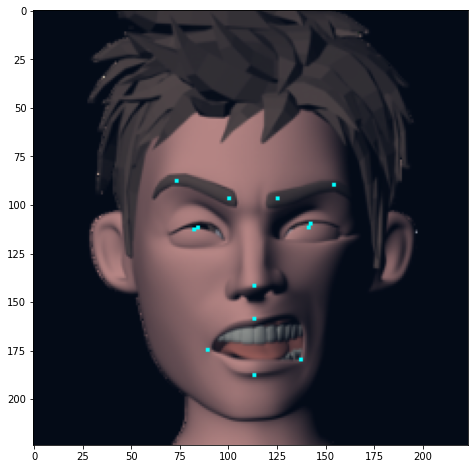

In [87]:
# create labeling
img_idx = 147
print("label:", int(train_data[1][img_idx]))

# l_eye, r_eye, nose, l_eyebrow_ext, l_eyebrow_int, r_eyebrow_int, r_eyebrow_ext,
# l_corner_mouth, up_mouth, r_corner_mouth, lower_mouth,
# l_lower_eyelid, r_lower_eyelid

# [x, y] -> [horizontal, vertical]
lmk_pos = {0: [[[85, 112], [142, 112], [114, 144], [74, 94], [102, 101], [125, 100], [155, 94], [90, 169], [114, 160], [136, 167], [115, 175], [83, 113], [143, 114]]],  # 0 Ray
           1: [[[86, 114], [142, 114], [114, 148], [67, 89], [100, 80], [128, 80], [160, 89], [86, 184], [114, 165], [140, 184], [114, 193], [82, 124], [145, 124]]],  # 1 Ray
           2: [[[91, 117], [137, 117], [114, 142], [70, 101], [100, 112], [130, 112], [160, 101], [95, 167], [114, 161], [131, 167], [114, 170], [83, 128], [145, 128]]],  # Bonnie
           3: [[[88, 103], [139, 103], [114, 139], [74, 74], [99, 75], [128, 75], [154, 74], [85, 154], [114, 154], [145, 151], [114, 174], [84, 110], [142, 110]]],  # 3 Jules
           4: [[[91, 117], [137, 117], [114, 142], [70, 99], [101, 110], [127, 110], [159, 99], [95, 174], [114, 163], [132, 174], [114, 175], [83, 128], [145, 128]]],  # 4 Bonnie
           5: [[[97, 95], [130, 95], [114, 118], [88, 71], [105, 70], [123, 70], [140, 73], [86, 164], [113, 143], [140, 164], [114, 170], [95, 100], [134, 100]]],  # 5 Malcolm
           6: [[[91, 117], [137, 117], [114, 142], [74, 91], [101, 94], [125, 94], [154, 91], [98, 170], [114, 164], [132, 170], [114, 176], [83, 128], [145, 128]]],  # 6 Bonnie
           7: [[[91, 117], [137, 117], [114, 142], [74, 93], [102, 84], [125, 85], [154, 95], [87, 184], [114, 162], [142, 184], [114, 190], [83, 126], [145, 126]]],  # 7 Bonnie
           8: [[[86, 114], [142, 114], [114, 147], [70, 84], [98, 78], [130, 78], [155, 84], [84, 180], [114, 163], [142, 180], [114, 186], [84, 122], [145, 122]]],  # 8 Ray
           9: [[[84, 109], [147, 109], [112, 152], [60, 82], [98, 72], [126, 72], [164, 82], [83, 185], [112, 171], [140, 186], [112, 188], [74, 130], [150, 130]]],  # 9 Aia
           10: [[[88, 132], [142, 132], [116, 159], [70, 105], [101, 108], [129, 108], [160, 105], [98, 178], [116, 174], [134, 177], [116, 183], [81, 138], [150, 138]]],  # Mery
           11: [[[81, 113], [143, 113], [112, 152], [60, 80], [98, 72], [126, 72], [164, 80], [84, 193], [112, 169], [139, 193], [112, 198], [74, 128], [150, 128]]],  # 11 Aia
           12: [[[91, 117], [137, 117], [114, 142], [70, 93], [98, 92], [130, 92], [155, 92], [95, 168], [114, 162], [132, 168], [114, 172], [84, 127], [145, 127]]],  # 12 Bonnie
           13: [[[81, 113], [144, 113], [112, 152], [57, 86], [96, 88], [128, 89], [164, 84], [89, 172], [112, 167], [137, 171], [112, 181], [74, 127], [150, 127]]],  # 13 Aia
           14: [[[88, 103], [138, 103], [114, 139], [74, 70], [99, 71], [128, 71], [155, 71], [97, 172], [114, 158], [130, 172], [114, 190], [84, 113], [142, 113]]],  # 14 Jules
           15: [[[86, 114], [142, 114], [114, 144], [67, 93], [100, 84], [128, 84], [160, 93], [89, 178], [114, 165], [137, 178], [114, 174], [84, 119], [144, 119]]],  # 15 Ray
           16: [[[92, 118], [137, 118], [114, 142], [74, 92], [102, 84], [126, 86], [154, 93], [87, 186], [114, 163], [141, 185], [114, 199], [83, 126], [145, 126]]], # 16 Bonnie
           17: [[[88, 103], [138, 103], [114, 139], [74, 95], [101, 83], [125, 83], [155, 96], [94, 165], [114, 156], [132, 165], [114, 164], [85, 107], [141, 107]]],  # 17 Jules
           18: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 72], [128, 72], [164, 81], [79, 190], [112, 166], [143, 190], [112, 201], [74, 126], [150, 126]]],  # 18 Aia
           19: [[[91, 117], [137, 117], [114, 142], [74, 92], [100, 96], [129, 88], [154, 82], [92, 175], [114, 153], [135, 175], [114, 187], [83, 118], [145, 119]]],  # 19 Bonnie
           20: [[[88, 103], [138, 103], [114, 139], [74, 81], [99, 81], [128, 81], [155, 80], [95, 160], [114, 156], [132, 160], [114, 165], [84, 112], [142, 112]]],  # 20 Jules
           21: [[[86, 114], [142, 114], [114, 147], [70, 89], [98, 90], [130, 90], [155, 88], [90, 172], [114, 168], [137, 171], [114, 180], [84, 123], [145, 123]]],  # 21 Ray
           22: [[[86, 114], [142, 114], [114, 147], [70, 100], [101, 88], [126, 87], [155, 100], [91, 178], [114, 166], [136, 176], [114, 178], [84, 120], [145, 120]]],  # 22 Ray
           23: [[[88, 132], [142, 132], [116, 159], [70, 116], [101, 130], [129, 130], [160, 116], [99, 178], [116, 173], [134, 177], [116, 183], [81, 143], [150, 142]]],  # Mery
           24: [[[91, 117], [137, 117], [114, 146], [73, 94], [100, 95], [129, 95], [154, 94], [92, 166], [114, 160], [135, 166], [114, 171], [83, 127], [145, 127]]],  # 24 Bonnie
           25: [[[81, 113], [144, 113], [112, 152], [57, 84], [96, 88], [128, 88], [164, 83], [89, 172], [112, 167], [137, 171], [112, 180], [74, 127], [150, 127]]],  # 25 Aia
           26: [[[85, 112], [142, 112], [114, 144], [74, 96], [102, 101], [125, 99], [155, 93], [90, 166], [114, 158], [135, 165], [115, 170], [83, 113], [143, 114]]],  # 26 Ray
           27: [[[88, 103], [138, 103], [114, 139], [74, 74], [99, 73], [128, 73], [155, 74], [98, 170], [114, 156], [129, 170], [114, 191], [84, 113], [142, 113]]],  # 27 Jules
           28: [[[97, 95], [130, 95], [114, 118], [88, 69], [105, 65], [123, 65], [140, 70], [87, 164], [113, 142], [139, 164], [114, 170], [94, 103], [135, 103]]],  # 28 Malcolm
           29: [[[91, 117], [137, 117], [114, 142], [74, 91], [101, 94], [124, 94], [154, 91], [98, 170], [114, 164], [132, 170], [114, 176], [83, 128], [145, 128]]],  # 29 Bonnie
           30: [[[91, 117], [137, 117], [114, 142], [74, 91], [99, 92], [128, 92], [154, 91], [78, 159], [114, 156], [150, 158], [114, 186], [83, 118], [145, 118]]],  # 30 Bonnie
           31: [[[88, 132], [142, 132], [116, 159], [70, 116], [101, 107], [129, 107], [160, 116], [96, 184], [116, 173], [134, 184], [116, 183], [81, 138], [150, 138]]],  # Mery
           32: [[[91, 117], [137, 117], [114, 142], [74, 92], [100, 97], [128, 96], [154, 91], [92, 167], [114, 156], [136, 165], [114, 170], [83, 118], [145, 119]]],  # 32 Bonnie
           33: [[[91, 117], [137, 117], [114, 142], [75, 88], [100, 95], [128, 97], [154, 91], [91, 176], [114, 156], [135, 176], [114, 185], [83, 118], [145, 119]]],  # 33 Bonnie
           34: [[[91, 117], [137, 117], [114, 142], [75, 74], [100, 78], [128, 78], [154, 78], [96, 178], [114, 163], [131, 178], [114, 189], [83, 130], [145, 130]]],  # 34 Bonnie
           35: [[[88, 103], [138, 103], [114, 136], [74, 96], [101, 84], [125, 85], [155, 98], [92, 160], [114, 150], [134, 160], [114, 159], [85, 109], [141, 109]]],  # 35 Jules
           36: [[[80, 114], [145, 114], [112, 147], [60, 92], [98, 76], [126, 76], [164, 92], [88, 179], [112, 167], [135, 179], [112, 182], [74, 121], [150, 121]]],  # 36 Aia
           37: [[[86, 114], [142, 114], [114, 147], [70, 91], [98, 91], [130, 90], [155, 90], [90, 172], [114, 168], [137, 171], [114, 180], [84, 123], [145, 123]]],  # 37 Ray
           38: [[[86, 114], [142, 114], [114, 147], [67, 93], [100, 108], [127, 108], [160, 93], [91, 171], [114, 164], [135, 171], [114, 174], [84, 125], [144, 125]]],  # 38 Ray
           39: [[[97, 94], [130, 94], [114, 120], [88, 80], [103, 75], [126, 75], [140, 80], [95, 158], [113, 149], [131, 158], [114, 160], [92, 98], [136, 98]]],  # 39 Malcom
           40: [[[88, 132], [142, 132], [116, 159], [70, 106], [100, 108], [129, 107], [160, 104], [88, 169], [116, 171], [138, 170], [116, 186], [81, 137], [150, 137]]],  # Mery
           41: [[[91, 117], [137, 115], [114, 142], [75, 85], [100, 94], [126, 96], [154, 91], [89, 174], [114, 157], [137, 175], [114, 185], [83, 119], [145, 117]]],  # 41 Bonnie
           42: [[[88, 132], [142, 132], [116, 159], [70, 107], [101, 110], [129, 110], [160, 107], [96, 178], [116, 174], [134, 177], [116, 183], [81, 140], [150, 140]]],  # Mery
           43: [[[86, 114], [142, 114], [114, 146], [70, 91], [99, 91], [129, 91], [155, 90], [86, 160], [114, 159], [143, 158], [114, 175], [84, 119], [145, 117]]],  # 43 Ray
           44: [[[91, 117], [137, 117], [114, 142], [70, 107], [101, 114], [127, 114], [159, 107], [95, 172], [114, 162], [133, 172], [114, 177], [83, 124], [145, 124]]],  # Bonnie
           45: [[[81, 113], [144, 113], [112, 152], [57, 84], [96, 84], [128, 84], [164, 83], [89, 172], [112, 167], [137, 171], [112, 181], [74, 127], [150, 127]]],  # 45 Aia
           46: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 69], [126, 69], [165, 80], [85, 200], [112, 169], [138, 200], [112, 212], [74, 133], [150, 133]]],  # 46 Aia
           47: [[[86, 114], [142, 114], [114, 147], [70, 100], [101, 90], [126, 90], [155, 98], [91, 174], [114, 165], [136, 174], [114, 175], [84, 117], [145, 117]]],  # 47 Ray
           48: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 79], [126, 79], [165, 80], [87, 177], [112, 166], [137, 177], [112, 205], [74, 130], [150, 130]]],  # 48 Aia
           49: [[[86, 114], [142, 114], [114, 147], [72, 91], [96, 91], [130, 90], [155, 90], [95, 170], [114, 165], [135, 169], [114, 178], [84, 123], [145, 123]]],  # 49 Ray
           50: [[[81, 113], [144, 113], [112, 152], [57, 84], [96, 84], [128, 84], [164, 83], [85, 167], [112, 165], [139, 166], [112, 185], [74, 117], [150, 118]]],  # 50 Aia
           51: [[[86, 114], [142, 114], [114, 147], [70, 88], [98, 79], [130, 79], [155, 88], [85, 180], [114, 163], [142, 180], [114, 190], [84, 122], [145, 122]]],  # Ray
           52: [[[88, 103], [138, 103], [113, 137], [74, 77], [99, 70], [125, 70], [155, 78], [86, 171], [113, 154], [137, 170], [113, 178], [84, 112], [142, 112]]],  # 52 Jules
           53: [[[97, 94], [130, 94], [114, 120], [88, 80], [103, 75], [126, 75], [140, 80], [95, 158], [113, 149], [131, 158], [114, 160], [92, 98], [136, 98]]],  # Malcolm
           54: [[[81, 113], [144, 113], [112, 152], [57, 103], [96, 114], [128, 114], [164, 103], [88, 173], [112, 166], [136, 173], [112, 180], [74, 126], [150, 126]]],  # 54 Aia
           55: [[[86, 114], [142, 114], [114, 147], [70, 86], [98, 81], [130, 81], [155, 84], [91, 188], [114, 172], [136, 188], [114, 209], [84, 126], [145, 126]]],  # 55 Ray
           56: [[[80, 110], [145, 110], [112, 147], [60, 100], [98, 82], [126, 82], [164, 100], [87, 184], [112, 167], [135, 182], [112, 181], [74, 113], [150, 113]]],  # Aia
           59: [[[91, 117], [137, 117], [114, 142], [72, 85], [100, 87], [128, 87], [156, 85], [98, 184], [114, 164], [129, 184], [114, 202], [83, 130], [145, 130]]],  # Bonnie
           60: [[[81, 113], [144, 113], [112, 148], [57, 86], [96, 91], [128, 91], [164, 86], [89, 167], [112, 160], [135, 168], [114, 179], [74, 114], [150, 113]]],  # 60 Aia
           61: [[[81, 113], [144, 113], [112, 152], [57, 83], [96, 82], [128, 82], [164, 82], [82, 166], [112, 165], [142, 165], [112, 182], [74, 121], [150, 121]]],  # Aia
           62: [[[86, 114], [142, 114], [114, 147], [70, 82], [98, 72], [128, 71], [154, 81], [85, 182], [114, 164], [143, 182], [114, 190], [84, 126], [145, 126]]],  # Ray
           65: [[[97, 94], [130, 94], [114, 120], [88, 80], [103, 88], [126, 88], [140, 80], [96, 152], [114, 147], [131, 152], [114, 156], [92, 103], [136, 103]]],  # 65 Malcolm
           66: [[[81, 113], [144, 113], [112, 152], [57, 90], [96, 112], [128, 112], [164, 91], [89, 170], [112, 163], [135, 170], [112, 174], [74, 129], [150, 128]]],   # Aia
           67: [[[86, 114], [142, 114], [114, 147], [67, 87], [105, 109], [124, 109], [156, 87], [86, 183], [114, 158], [138, 181], [114, 194], [84, 119], [144, 119]]],  # Ray
           68: [[[97, 94], [130, 94], [114, 120], [86, 71], [100, 72], [128, 71], [142, 70], [87, 142], [114, 144], [140, 141], [114, 154], [92, 96], [136, 96]]],  # 68 Malcolm
           70: [[[81, 113], [144, 113], [112, 152], [57, 81], [97, 80], [126, 80], [165, 80], [97, 181], [112, 173], [127, 181], [112, 198], [74, 130], [150, 130]]],  # Aia
           71: [[[85, 112], [142, 112], [114, 144], [74, 96], [101, 101], [126, 99], [155, 93], [90, 166], [114, 157], [135, 165], [115, 170], [83, 113], [143, 114]]],  # Ray
           72: [[[86, 114], [142, 114], [114, 147], [70, 80], [98, 74], [128, 74], [154, 79], [86, 187], [114, 164], [142, 187], [114, 201], [84, 125], [145, 125]]],  # Ray
           73: [[[86, 114], [142, 114], [114, 147], [72, 91], [99, 91], [128, 90], [155, 90], [94, 168], [114, 165], [135, 168], [114, 178], [84, 123], [145, 123]]],  # Ray
           74: [[[88, 103], [138, 103], [113, 137], [74, 76], [99, 68], [125, 68], [155, 77], [86, 177], [113, 154], [135, 177], [113, 184], [84, 112], [142, 112]]],  # Jules
           75: [[[85, 112], [142, 112], [114, 142], [74, 90], [101, 98], [126, 99], [155, 93], [88, 173], [114, 159], [138, 170], [115, 181], [83, 113], [143, 114]]],  # Ray
           76: [[[86, 114], [142, 114], [114, 147], [67, 87], [103, 109], [122, 109], [156, 87], [87, 182], [114, 158], [138, 181], [114, 194], [84, 119], [144, 119]]],  # Ray
           77: [[[97, 94], [130, 94], [114, 123], [86, 72], [100, 72], [129, 72], [143, 72], [93, 151], [114, 147], [136, 151], [114, 158], [92, 101], [136, 101]]],  # 77 Malcolm
           79: [[[88, 132], [142, 132], [116, 157], [70, 100], [100, 97], [129, 97], [160, 100], [92, 183], [116, 170], [136, 183], [116, 206], [81, 140], [150, 140]]],  # 79 Mery
           80: [[[88, 103], [138, 103], [114, 132], [74, 81], [101, 85], [127, 90], [155, 84], [90, 159], [114, 150], [134, 159], [114, 170], [85, 105], [141, 105]]],  # 80 Jules
           81: [[[88, 103], [138, 103], [114, 138], [74, 88], [100, 104], [128, 103], [155, 86], [89, 172], [114, 150], [137, 172], [114, 180], [85, 110], [141, 110]]],  # 81 Jules
           83: [[[88, 132], [142, 132], [116, 159], [70, 108], [100, 110], [129, 110], [160, 106], [88, 169], [116, 169], [140, 170], [116, 185], [81, 136], [150, 136]]],
           84: [[[86, 114], [142, 114], [114, 147], [72, 91], [99, 91], [128, 90], [155, 90], [94, 168], [114, 165], [135, 168], [114, 178], [84, 123], [145, 123]]],  # Ray
           89: [[[86, 114], [142, 114], [114, 147], [67, 92], [101, 107], [124, 107], [156, 93], [90, 172], [114, 164], [136, 172], [114, 179], [84, 123], [144, 123]]],  # Ray
           90: [[[97, 94], [130, 94], [114, 123], [86, 74], [103, 76], [126, 76], [143, 72], [94, 159], [114, 141], [136, 151], [114, 164], [92, 93], [136, 94]]],  # 90 Malcolm
           91: [[[88, 132], [142, 132], [116, 157], [70, 111], [100, 105], [129, 105], [160, 112], [91, 186], [116, 173], [138, 186], [115, 193], [81, 139], [150, 139]]], # 91 Mery
           92: [[[85, 112], [142, 112], [114, 142], [74, 90], [101, 98], [126, 99], [155, 94], [87, 174], [114, 161], [140, 170], [114, 188], [83, 115], [143, 114]]],  # Ray
           94: [[[81, 113], [144, 111], [112, 148], [57, 82], [96, 89], [128, 94], [164, 85], [89, 170], [112, 160], [138, 168], [117, 189], [74, 114], [150, 111]]],
           96: [[[97, 94], [130, 94], [114, 120], [86, 71], [100, 72], [128, 71], [142, 70], [86, 139], [114, 140], [142, 139], [114, 165], [92, 96], [136, 96]]],  # Malcolm
           98: [[[88, 103], [139, 103], [114, 137], [74, 74], [99, 74], [128, 74], [154, 75], [87, 151], [114, 152], [141, 151], [114, 162], [84, 108], [142, 108]]],  # Jules
           99: [[[86, 114], [142, 114], [114, 147], [67, 100], [101, 111], [124, 110], [156, 100], [90, 170], [114, 163], [136, 170], [114, 175], [84, 122], [144, 122]]],  # Ray
           100: [[[88, 103], [138, 103], [114, 140], [74, 89], [98, 99], [128, 99], [155, 86], [93, 164], [114, 157], [134, 164], [114, 167], [85, 114], [141, 113]]],  # Jules
           105: [[[86, 114], [142, 114], [114, 147], [70, 76], [98, 70], [128, 70], [154, 76], [86, 187], [114, 162], [142, 187], [114, 204], [84, 126], [145, 125]]],  # Ray
           114: [[[88, 101], [138, 103], [114, 132], [74, 87], [101, 92], [127, 89], [155, 83], [87, 154], [114, 150], [130, 165], [103, 177], [85, 102], [141, 105]]],  # Jules
           121: [[[88, 132], [142, 132], [116, 157], [70, 100], [100, 94], [129, 95], [160, 100], [100, 183], [116, 177], [130, 183], [116, 189], [81, 139], [150, 139]]],
           123: [[[86, 114], [142, 114], [114, 147], [67, 103], [101, 111], [125, 110], [156, 105], [90, 170], [114, 163], [136, 170], [114, 175], [84, 123], [144, 123]]],  # Ray
           124: [[[86, 114], [142, 114], [114, 146], [70, 91], [99, 91], [129, 91], [155, 90], [83, 161], [114, 159], [144, 161], [114, 182], [84, 118], [145, 118]]],   # 124 Ray
           125: [[[97, 94], [130, 94], [114, 123], [86, 71], [100, 72], [129, 72], [143, 71], [88, 156], [114, 147], [136, 158], [114, 180], [92, 102], [136, 104]]],  # 125 Malcolm
           126: [[[91, 117], [137, 117], [114, 142], [74, 99], [101, 89], [124, 88], [154, 99], [92, 175], [114, 162], [136, 175], [114, 175], [83, 124], [145, 124]]],  # Bonnie
           130: [[[86, 114], [142, 114], [114, 147], [70, 81], [98, 80], [130, 80], [155, 81], [89, 175], [114, 165], [138, 175], [114, 207], [84, 124], [145, 124]]],  # Ray
           135: [[[97, 94], [130, 94], [114, 123], [86, 76], [100, 76], [129, 76], [143, 76], [93, 146], [114, 145], [136, 146], [114, 153], [92, 99], [136, 99]]],  # Malcolm
           136: [[[97, 94], [130, 94], [114, 120], [88, 84], [106, 94], [123, 94], [142, 82], [98, 164], [114, 145], [131, 162], [114, 176], [92, 98], [136, 98]]],  # Malcolm
           138: [[[97, 94], [130, 94], [114, 123], [86, 69], [100, 69], [129, 69], [143, 69], [92, 156], [114, 147], [136, 156], [114, 174], [92, 102], [136, 103]]],  # Malcolm
           139: [[[86, 114], [142, 114], [114, 147], [70, 88], [98, 84], [130, 84], [155, 86], [98, 180], [114, 170], [130, 180], [114, 207], [84, 125], [145, 125]]],  # Ray
           142: [[[85, 112], [142, 112], [114, 142], [74, 91], [101, 97], [126, 94], [155, 85], [88, 170], [114, 159], [136, 172], [114, 188], [83, 113], [143, 114]]],  # Ray
           145: [[[86, 114], [142, 114], [114, 147], [72, 91], [99, 91], [128, 90], [155, 91], [95, 168], [114, 165], [135, 166], [114, 178], [84, 123], [145, 123]]],  # Ray
           146: [[[86, 114], [142, 114], [114, 147], [70, 100], [100, 88], [126, 88], [155, 98], [92, 176], [114, 165], [136, 176], [114, 177], [84, 119], [145, 119]]],  # Ray
           147: [[[85, 112], [142, 112], [114, 142], [74, 88], [101, 97], [126, 97], [155, 90], [90, 175], [114, 159], [138, 180], [114, 188], [83, 113], [143, 110]]],  # Ray
           148: [[[86, 114], [142, 114], [114, 147], [72, 89], [99, 89], [128, 89], [155, 88], [92, 166], [114, 163], [135, 166], [113, 176], [84, 122], [145, 122]]],  # Ray
           151: [[[86, 114], [142, 114], [114, 147], [67, 93], [101, 106], [125, 106], [156, 95], [92, 176], [114, 166], [134, 177], [114, 178], [84, 124], [144, 125]]],  # Ray
           159: [[[91, 117], [137, 117], [114, 142], [74, 105], [102, 90], [124, 88], [154, 105], [94, 183], [114, 162], [134, 183], [114, 182], [83, 122], [145, 122]]],  # Bonnie
           160: [[[86, 114], [142, 114], [114, 147], [70, 83], [98, 81], [130, 81], [155, 82], [88, 174], [114, 164], [139, 173], [114, 204], [84, 124], [145, 124]]],  # Ray
           163: [[[88, 103], [138, 103], [114, 139], [74, 81], [99, 81], [128, 81], [155, 80], [93, 160], [114, 156], [134, 160], [114, 166], [84, 112], [142, 112]]],  # Jules
           164: [[[86, 114], [142, 114], [114, 147], [70, 84], [98, 77], [128, 78], [154, 84], [85, 180], [114, 161], [143, 180], [114, 191], [84, 123], [145, 123]]],  # Ray
           166: [[[86, 114], [142, 114], [114, 146], [70, 84], [99, 85], [129, 87], [155, 88], [85, 163], [114, 161], [144, 159], [114, 189], [84, 120], [145, 119]]],  # Ray
           180: [[[97, 92], [130, 92], [114, 123], [86, 72], [103, 75], [126, 76], [143, 72], [90, 150], [114, 141], [137, 151], [113, 166], [92, 93], [136, 94]]],  # Malcolm
           182: [[[91, 117], [137, 117], [114, 142], [74, 88], [99, 89], [128, 89], [154, 88], [80, 159], [114, 156], [148, 158], [114, 183], [83, 120], [145, 120]]],  # Bonnie
           189: [[[86, 114], [142, 114], [114, 147], [70, 82], [98, 80], [130, 80], [155, 80], [97, 186], [114, 171], [130, 186], [114, 210], [84, 126], [145, 126]]],  # Ray
           203: [[[88, 132], [142, 132], [116, 159], [70, 121], [101, 114], [129, 114], [160, 121], [95, 179], [116, 171], [135, 178], [116, 179], [81, 138], [150, 138]]],
           212: [[[86, 114], [142, 114], [114, 146], [70, 87], [99, 86], [129, 87], [155, 86], [84, 161], [114, 160], [144, 160], [114, 180], [84, 118], [145, 118]]],  # Ray
           219: [[[86, 114], [142, 114], [114, 147], [70, 84], [98, 80], [130, 80], [155, 84], [91, 179], [114, 168], [136, 179], [114, 202], [84, 124], [145, 124]]],  # Ray
           227: [[[86, 114], [142, 114], [114, 147], [70, 100], [100, 88], [126, 88], [155, 98], [92, 176], [114, 165], [136, 176], [114, 179], [84, 117], [145, 117]]],  # Ray
           248: [[[86, 114], [142, 114], [114, 147], [70, 81], [98, 79], [130, 79], [155, 80], [90, 176], [114, 166], [137, 176], [114, 208], [84, 124], [145, 124]]],  # Ray
           261: [[[88, 132], [142, 132], [116, 157], [70, 104], [101, 99], [129, 99], [160, 104], [90, 187], [116, 170], [139, 186], [115, 195], [81, 139], [150, 139]]],
           270: [[[88, 132], [142, 132], [116, 155], [70, 114], [100, 117], [130, 116], [160, 112], [92, 172], [116, 168], [134, 179], [114, 191], [81, 132], [150, 132]]],  # Mery
           287: [[[88, 132], [142, 132], [116, 159], [70, 111], [101, 126], [129, 128], [160, 112], [94, 180], [116, 170], [136, 177], [116, 186], [81, 140], [150, 140]]],
           294: [[[86, 114], [142, 114], [114, 146], [70, 90], [100, 90], [129, 89], [155, 88], [84, 161], [114, 160], [144, 160], [114, 181], [84, 118], [145, 118]]],  # Ray
           328: [[[86, 114], [142, 114], [114, 146], [70, 85], [100, 86], [129, 86], [155, 85], [84, 159], [114, 160], [144, 159], [114, 176], [84, 118], [145, 118]]],  # Ray
           420: [[[86, 114], [142, 114], [114, 147], [70, 101], [100, 88], [126, 88], [155, 101], [90, 177], [114, 165], [136, 178], [114, 181], [84, 117], [145, 117]]],  # Ray
           461: [[[88, 132], [142, 132], [116, 155], [70, 114], [100, 116], [130, 116], [160, 112], [92, 172], [116, 167], [135, 174], [114, 181], [81, 132], [150, 132]]],
           468: [[[86, 114], [142, 114], [114, 147], [70, 95], [102, 85], [126, 86], [155, 95], [90, 177], [114, 164], [136, 176], [114, 174], [84, 118], [145, 118]]],  # Ray
           504: [[[86, 114], [142, 114], [114, 146], [70, 91], [100, 89], [129, 89], [155, 89], [82, 159], [114, 159], [145, 159], [114, 177], [84, 117], [145, 117]]],  # Ray
           }

print("len lmk_pos", len(lmk_pos))
display_images([train_data[0][img_idx]], lmks=lmk_pos[img_idx], lmk_size=3, size_img=8, pre_processing='VGG19')

In [8]:
train_lmk_idx = np.array([[[21], [43], [38], [15], [55], [1], [0]],
                         [[6], [30], [2], [126], [34], [7], [19]],
                         [[20], [3], [81], [17], [14], [52], [80]],
                         [[77], [68], [65], [39], [125], [5], [90]],
                         [[13], [50], [54], [36], [48], [9], [60]],
                         [[10], [40], [23], [31], [79], [91], [270]]])
print("shape train_lmk_idx", np.shape(train_lmk_idx))

shape train_lmk_idx (6, 7, 1)


## Train RBFs

### 1) Transform images to semantic space

In [9]:
# load and define extraction model
v4_model = load_extraction_model(config, input_shape=tuple(config["input_shape"]))
v4_model = tf.keras.Model(inputs=v4_model.input, outputs=v4_model.get_layer(config['v4_layer']).output)
size_ft = tuple(np.shape(v4_model.output)[1:3])
print("[LOAD] size_ft", size_ft)
print("[LOAD] Model loaded")

1Metal device set to: Apple M1 Pro
 Physical GPUs, 1 Logical GPUs


2022-08-04 07:32:07.412170: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-04 07:32:07.412303: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


[LOAD] size_ft (56, 56)
[LOAD] Model loaded


In [10]:
def predict_v4(data):
    preds = []
    for i in tqdm.tqdm((range(len(data[0])))):
        # predict v4 output
        pred = v4_model.predict(np.expand_dims(data[0][i], axis=0), verbose=0)
        preds.append(pred)
    preds = np.squeeze(np.array(preds))
    print("[predict_v4] shape prediction", np.shape(preds))

    # WHAT TENSORFLOW!!!!!!!!! HOW COMES THIS CREATE WEIRD PATCHES SCRAPPED AROUND?!?!?!?!?
    # preds = v4_model.predict(data[0], verbose=1)
    # print("[predict_v4] shape prediction", np.shape(preds))
    # print()

    # get feature maps that mimic a semantic selection pipeline
    # keep only highest IoU semantic score
    # FR predictions
    eyes_preds = preds[..., config['best_eyes_IoU_ft']]
    print("[predict_v4] shape eyes semantic feature selection", np.shape(eyes_preds))
    nose_preds = preds[..., config['best_nose_IoU_ft']]
    print("[predict_v4] shape nose semantic feature selection", np.shape(nose_preds))
    fr_preds = np.concatenate((eyes_preds, nose_preds), axis=3)
    print("[predict_v4] shape fr_preds", np.shape(fr_preds))
    print()

    # FER predictions
    eyebrow_preds = preds[..., config['best_eyebrow_IoU_ft']]
    print("[predict_v4] shape eyebrow semantic feature selection", np.shape(eyebrow_preds))
    lips_preds = preds[..., config['best_lips_IoU_ft']]
    print("[predict_v4] shape lips semantic feature selection", np.shape(lips_preds))
    fer_preds = np.concatenate((eyebrow_preds, lips_preds), axis=3)
    print("[predict_v4] shape fer_preds", np.shape(fer_preds))

    return fr_preds, fer_preds

In [11]:
train_FR_preds, train_FER_preds = predict_v4([train_data[0][:600], train_data[1][:600]])
print("shape train_FR_preds", np.shape(train_FR_preds))
print("shape train_FER_preds", np.shape(train_FER_preds))

  0%|          | 0/600 [00:00<?, ?it/s]2022-08-04 07:32:07.805812: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-04 07:32:07.850299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 600/600 [00:16<00:00, 36.51it/s]


[predict_v4] shape prediction (600, 56, 56, 256)
[predict_v4] shape eyes semantic feature selection (600, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (600, 56, 56, 61)
[predict_v4] shape fr_preds (600, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (600, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (600, 56, 56, 16)
[predict_v4] shape fer_preds (600, 56, 56, 18)
shape train_FR_preds (600, 56, 56, 68)
shape train_FER_preds (600, 56, 56, 18)


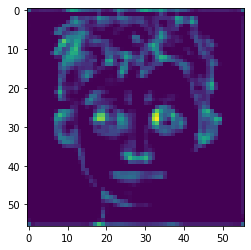

In [12]:
# control one feature map!!!!!! I was getting some super strange patch here...
display_image(train_FR_preds[21, ..., 0])

In [13]:
# filter predictions with train_lmk_idx
train_FR_lmk_preds = train_FR_preds[np.reshape(train_lmk_idx, -1)]
print("shape train_FR_lmk_preds", np.shape(train_FR_lmk_preds))
train_FER_lmk_preds = train_FER_preds[np.reshape(train_lmk_idx, -1)]
print("shape train_FER_lmk_preds", np.shape(train_FER_lmk_preds))

shape train_FR_lmk_preds (42, 56, 56, 68)
shape train_FER_lmk_preds (42, 56, 56, 18)


In [14]:
def filter_lmk_pos(lmk_pos, lmk_idx):
    filter_lmk_pos = []
    test_lmk_idx = []
    for i in range(np.shape(lmk_idx)[0]):
        for j in range(np.shape(lmk_idx)[1]):
            for k in range(np.shape(lmk_idx[i, j])[0]):
                test_lmk_idx.append(lmk_idx[i, j, k])
                filter_lmk_pos.append(lmk_pos[lmk_idx[i, j, k]][0])

    return np.array(filter_lmk_pos)

In [15]:
def construct_patterns(preds, pos, size, ratio=1):
    n_lmks = np.shape(pos)[1]
    n_patterns = np.shape(preds)[0]  # == n_images

    pad_x = int(size[0] / 2)
    pad_y = int(size[1] / 2)
    patterns = np.zeros((n_patterns, n_lmks, size[1], size[0], np.shape(preds)[-1]))

    for i in range(n_patterns):
        for j in range(n_lmks):
            x_pos = np.round(pos[i, j, 0] / ratio).astype(int)
            y_pos = np.round(pos[i, j, 1] / ratio).astype(int)
            x_patch = [x_pos - pad_x, x_pos + pad_x + 1]
            y_patch = [y_pos - pad_y, y_pos + pad_y + 1]
            patterns[i, j] = preds[i, y_patch[0]:y_patch[1], x_patch[0]:x_patch[1]]  # image x/y are shifted

    return patterns

### Construct RBF patterns

In [16]:
# declare RBF parameters
posX = np.round(86 / 4).astype(int)
posY = np.round(114 / 4).astype(int)
print("len lmk_pos", len(lmk_pos))
print("shape lmk_pos[0]", np.shape(lmk_pos[0]))
print("shape train_lmk_idx", np.shape(train_lmk_idx))
filt_lmk_pos = filter_lmk_pos(lmk_pos, train_lmk_idx)
print("filt_lmk_pos (n_patterns, n_lmks, pos)", np.shape(filt_lmk_pos))
FR_patterns = construct_patterns(train_FR_lmk_preds, filt_lmk_pos[:, :3], (7, 7), ratio=224/56)
FER_patterns = construct_patterns(train_FER_lmk_preds, filt_lmk_pos[:, 3:], (7, 7), ratio=224/56)

print("(n_patterns, n_lmks, size, size, n_ft_map)")
print("shape FR_patterns", np.shape(FR_patterns))
print("shape FER_patterns", np.shape(FER_patterns))

len lmk_pos 120
shape lmk_pos[0] (1, 13, 2)
shape train_lmk_idx (6, 7, 1)
filt_lmk_pos (n_patterns, n_lmks, pos) (42, 13, 2)
(n_patterns, n_lmks, size, size, n_ft_map)
shape FR_patterns (42, 3, 7, 7, 68)
shape FER_patterns (42, 10, 7, 7, 18)


In [299]:
def compute_activity_maps(ft_maps, patterns, sigmas=1, lmk_idx=None, disable_tqdm=False):
    """
    The function "convolve" with a RBF kernel all the patterns within the given feature maps

    small sigma => more selective
    large sigma => more robust

    :param ft_maps: (n_images, size, size, n_ft_maps)
    :param patterns: (n_patterns, n_lmks, k_size, k_size, n_ft_maps)
    :param sigmas:
    :return: activity_map (n_images, n_patterns, n_lmks, size, size)
    """
    # declare activity map
    if lmk_idx is None:
        activity_map = np.zeros((np.shape(ft_maps)[0], np.shape(patterns)[0], np.shape(patterns)[1], np.shape(ft_maps)[1], np.shape(ft_maps)[2]))
    else:
        activity_map = np.zeros((np.shape(ft_maps)[0], np.shape(patterns)[0], 1, np.shape(ft_maps)[1], np.shape(ft_maps)[2]))

    # compute padding
    pad_x = int(np.shape(patterns)[2] / 2)
    pad_y = int(np.shape(patterns)[3] / 2)

    # pad feature maps
    padded_ft_maps = np.zeros((np.shape(ft_maps)[0], np.shape(ft_maps)[1] + 2 * pad_x, np.shape(ft_maps)[2] + 2 * pad_y, np.shape(ft_maps)[3]))

    # compensate for padding of zeros
    if pad_x == 0 and pad_y== 0:
        padded_ft_maps = ft_maps
    elif pad_x == 0 and pad_y != 0:
        padded_ft_maps[:, :, pad_y:-pad_y, :] = ft_maps
    elif pad_x != 0 and pad_y == 0:
        padded_ft_maps[:, pad_x:-pad_x, :, :] = ft_maps
    else:
        padded_ft_maps[:, pad_x:-pad_x, pad_y:-pad_y, :] = ft_maps


    if lmk_idx is None:
        n_lmk = np.shape(patterns)[1]
        lmk_indexes = range(n_lmk)
    else:
        lmk_indexes = lmk_idx

    for l, l_idx in tqdm.tqdm(enumerate(lmk_indexes), disable=disable_tqdm):

        if isinstance(sigmas,int):
            sigma = sigmas
        elif isinstance(sigmas, np.int64):
            sigma = sigmas
        elif isinstance(sigmas, np.ndarray):
            sigma = sigmas[l]
        elif isinstance(sigmas,tuple):
            sigma = sigmas[l]
        else:
            raise NotImplementedError("sigmas of type {} is not implemented yet".format(type(sigmas)))

        # expand pattern to match dimension to patch
        pattern = np.repeat(np.expand_dims(patterns[:, l_idx], axis=0), np.shape(ft_maps)[0], axis=0)

        # compute for each position of the feature maps
        for i in range(pad_x, np.shape(ft_maps)[1] + pad_x):
            for j in range(pad_y, np.shape(ft_maps)[2] + pad_y):
                # get patch with matching size of the pattern
                x_pos = [i-pad_x, i+pad_x + 1]
                y_pos = [j-pad_y, j+pad_y + 1]
                patch = padded_ft_maps[:, x_pos[0]:x_pos[1], y_pos[0]:y_pos[1]]

                # expand patch and patterns to match dimensions (n_images, n_patterns, k_size, k_size, n_ft_maps)
                patch = np.repeat(np.expand_dims(patch, axis=1), len(patterns), axis=1)

                # compute diff between pattern and patch
                # (n_images, n_patterns, n_lmks, size, size, n_ft_map)
                diff = patch - pattern

                # compute activity
                flat_diff = np.reshape(diff, (np.shape(diff)[0], np.shape(diff)[1], -1))  # flatten 3 last dimensions to apply norm on# single axis
                activity = np.exp(-np.linalg.norm(flat_diff, ord=2, axis=2) ** 2 / 2 / sigma ** 2)

                # save activity
                activity_map[..., l, i - pad_x, j - pad_y] = activity

    return activity_map

In [18]:
import time
st = time.time()
activity_maps = compute_activity_maps(train_FR_preds[:5], FR_patterns, sigmas=0.01)  # test that the patterns are very specific
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')
print("shape activity_maps", np.shape(activity_maps))

Execution time: 18.705868005752563 seconds
shape activity_maps (5, 42, 3, 56, 56)


In [19]:
# max pool activities
max_pool_activities = np.amax(activity_maps, axis=1)
max_pool_activities_arg = np.argmax(activity_maps, axis=1)
print("shape max_pool_activity", np.shape(max_pool_activities))
print("shape max_pool_activities_arg", np.shape(max_pool_activities_arg))

shape max_pool_activity (5, 3, 56, 56)
shape max_pool_activities_arg (5, 3, 56, 56)


In [20]:
def display_FR_lmk(image, max_pool_activities, activities):
    print("shape activities", np.shape(activities))
    # display feature maps activity
    display_image(image, pre_processing='VGG19')
    display_images(max_pool_activities)
    for i in range(np.shape(activities)[1]):
        max_pool_over_maps = np.amax(activities[:, i], axis=(1, 2))
        pattern_idx = np.where(max_pool_over_maps >= .1)[0]

        unrav_idx = []
        for p in pattern_idx:
            unrav_idx.append(np.unravel_index(p, (6, 7)))

        print("lmk {} comes from pattern: {} - {}".format(i, pattern_idx, unrav_idx))

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [6] - [(0, 6)]
lmk 1 comes from pattern: [6] - [(0, 6)]
lmk 2 comes from pattern: [6] - [(0, 6)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [5] - [(0, 5)]
lmk 1 comes from pattern: [5] - [(0, 5)]
lmk 2 comes from pattern: [5] - [(0, 5)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [9] - [(1, 2)]
lmk 1 comes from pattern: [9] - [(1, 2)]
lmk 2 comes from pattern: [9] - [(1, 2)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [15] - [(2, 1)]
lmk 1 comes from pattern: [15] - [(2, 1)]
lmk 2 comes from pattern: [15] - [(2, 1)]

shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [] - []
lmk 1 comes from pattern: [] - []
lmk 2 comes from pattern: [] - []



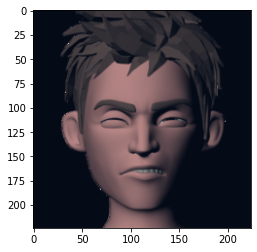

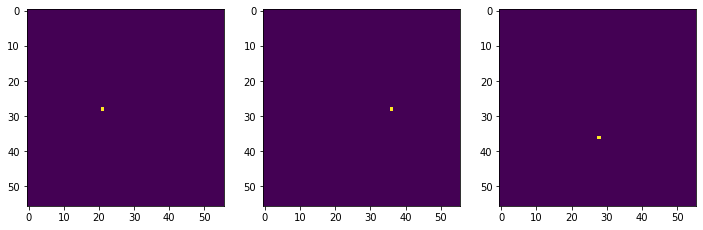

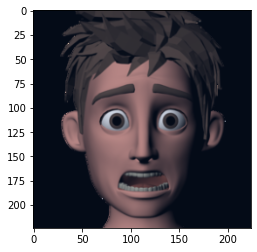

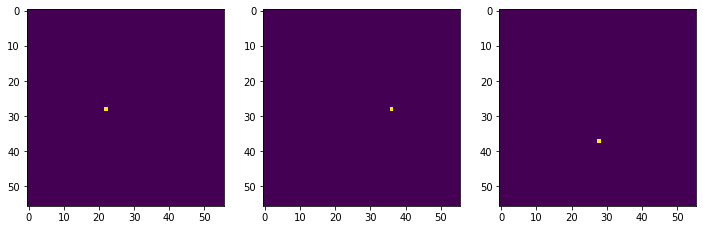

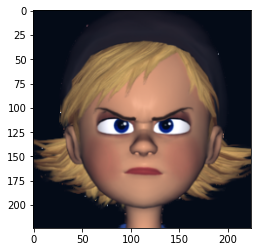

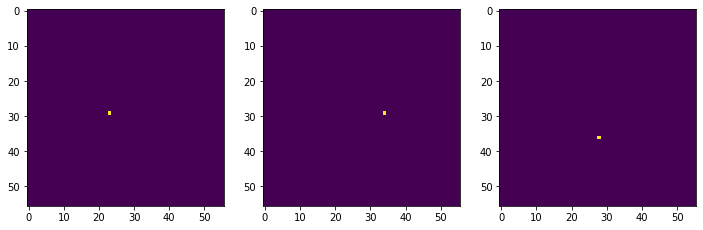

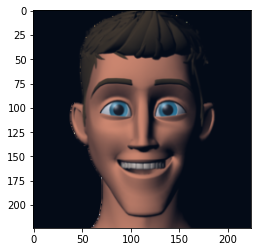

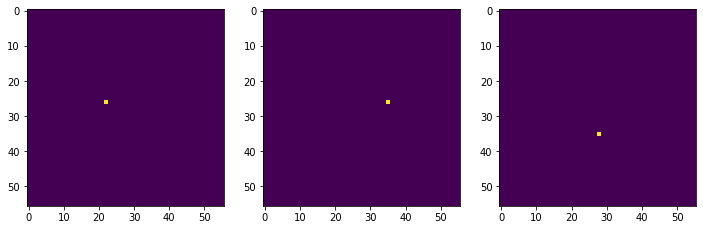

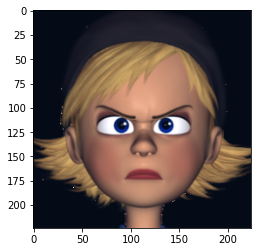

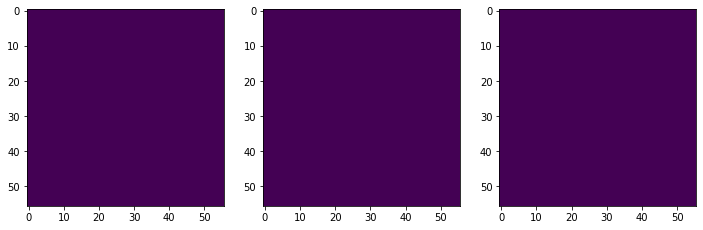

In [21]:
for i in range(len(activity_maps)):
    display_FR_lmk(train_data[0][i], max_pool_activities[i], activity_maps[i])
    print()

In [22]:
def find_patch_in_image(pos):
    # plot image that is responsible for activity
    resp_image_idx = train_lmk_idx[pos[0], pos[1]][0]
    print("resp_image_idx", resp_image_idx)
    pos = lmk_pos[resp_image_idx][0][1]
    print("position of pattern", pos)
    display_image(train_data[0][resp_image_idx][pos[1]-16:pos[1]+17, pos[0]-16:pos[0]+17], pre_processing='VGG19')

resp_image_idx 68
position of pattern [130, 94]


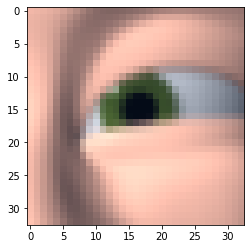

In [23]:
find_patch_in_image((3, 1))  # plot the patch responsible to train the pattern (3, 1)

## Raw optimization of RBF sigma value

In [24]:
def optimize_sigmas_by_detection(preds, patterns, threshold=0.1, lr_rate=100, batch_size=32, sigmas=None):
    """
    sigmas are scaled up until all images have a detected landmarks

    :param preds:
    :param patterns:
    :param threshold:
    :param lr_rate:
    :param batch_size:
    :param sigmas:
    :return:
    """
    if sigmas is None:
        sigmas = np.ones(np.shape(patterns)[1]) * lr_rate

    n_data = len(preds)
    do_continue = True

    def generator():
        """
        simply used to have a while loop using tqdm
        :return:
        """
        while do_continue:
            yield

    def batch(iterable, n=1):
        l = len(iterable)
        for ndx in range(0, l, n):
            yield iterable[ndx:min(ndx + n, l)]

    for _ in tqdm.tqdm(generator()):
        n_zeros = 0
        min_activities = np.ones(np.shape(sigmas)) * 2
        # compute activity maps
        for x in batch(range(n_data), batch_size):
            activity_maps = compute_activity_maps(preds[x], patterns, sigmas=sigmas)

            # max pool activity
            max_pool_activities = np.amax(activity_maps, axis=1)

            # threshold
            max_pool_activities[max_pool_activities < threshold] = 0.0

            # check if there's any non_activity
            activity_sum = np.sum(max_pool_activities, axis=(2, 3))

            # get minimum values per landmark
            min_activity = np.amin(activity_sum, axis=0)
            # keep track of the min activity per epoch
            min_activities = np.minimum(min_activities, min_activity)

            # get the number of activity maps that has zero activity
            n_zeros += len(np.where(activity_sum == 0)[0])

        print("min_activities")
        print(min_activities)
        # if there's still activity maps with zero activity, increase the value of sigma and start again
        if n_zeros > 0:
            # update only sigmas that doesn not reach the threshold
            sigmas[np.argwhere(min_activities < threshold)] += lr_rate
            print("new sigmas")
            print(sigmas)
        else:
            do_continue = False

    return sigmas

In [25]:
# sigmas = optimize_sigmas_by_detection(train_FR_preds, FR_patterns, sigmas=np.array([10600, 8600, 2900]))
# sigmas = optimize_sigmas_by_detection(train_FR_preds[:100], FR_patterns, sigmas=np.array([11500, 12100, 10000]))
# print("-------------------")
# print("sigmas", sigmas)

In [26]:
sigmas = np.array([10600, 8600, 2900])
sigmas = np.array([11500, 12100, 10000])
# compute activity maps
activity_maps = compute_activity_maps(train_FR_preds[:5], FR_patterns, sigmas=sigmas)

# max pool activity
max_pool_activities = np.amax(activity_maps, axis=1)
argmax_pool_activities = np.argmax(activity_maps, axis=1)
print("shape max_pool_activities", np.shape(max_pool_activities))
print("shape argmax_pool_activities", np.shape(argmax_pool_activities))
print("min max max_pool_activities")
print(np.amin(max_pool_activities, axis=(1, 2 ,3)))
print(np.amax(max_pool_activities, axis=(1, 2, 3)))

# threshold activity to remove small noise
max_pool_activities[max_pool_activities < 0.1] = 0.0

# check if there's any non_activity
activity_sum = np.sum(max_pool_activities, axis=(2, 3))
print("activity_sum")
print(activity_sum)
print(np.where(activity_sum == 0)[0])
n_zeros = len(np.where(activity_sum == 0)[0])
print("n_zeros:", n_zeros)

shape max_pool_activities (5, 3, 56, 56)
shape argmax_pool_activities (5, 3, 56, 56)
min max max_pool_activities
[0.002 0.    0.    0.    0.   ]
[1.    1.    1.    1.    0.829]
activity_sum
[[4.607 6.176 2.287]
 [1.648 2.235 2.639]
 [1.101 1.312 1.825]
 [1.903 2.659 2.445]
 [0.26  1.246 1.665]]
[]
n_zeros: 0


i 0
shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [6 8] - [(0, 6), (1, 1)]
lmk 1 comes from pattern: [ 1  6  8 17 20 34] - [(0, 1), (0, 6), (1, 1), (2, 3), (2, 6), (4, 6)]
lmk 2 comes from pattern: [ 0  1  2  3  4  5  6 14 15 16 17 18 22 28 29 30 32 33] - [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (3, 1), (4, 0), (4, 1), (4, 2), (4, 4), (4, 5)]

i 1
shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [ 0  4  5 18 19] - [(0, 0), (0, 4), (0, 5), (2, 4), (2, 5)]
lmk 1 comes from pattern: [ 0  4  5 15 18 19] - [(0, 0), (0, 4), (0, 5), (2, 1), (2, 4), (2, 5)]
lmk 2 comes from pattern: [ 0  1  2  3  4  5  6 14 15 16 18 19 23 31 33] - [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (2, 0), (2, 1), (2, 2), (2, 4), (2, 5), (3, 2), (4, 3), (4, 5)]

i 2
shape activities (42, 3, 56, 56)
lmk 0 comes from pattern: [8 9] - [(1, 1), (1, 2)]
lmk 1 comes from pattern: [7 8 9] - [(1, 0), (1, 1), (1, 2)]
lmk 2 comes from pa

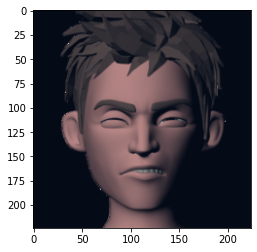

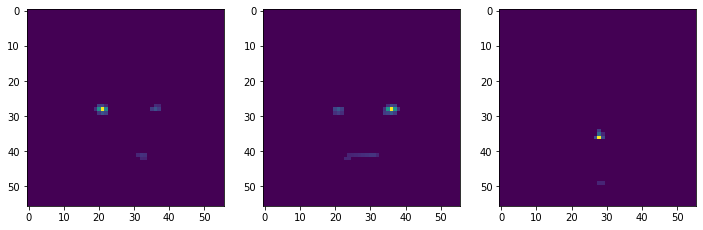

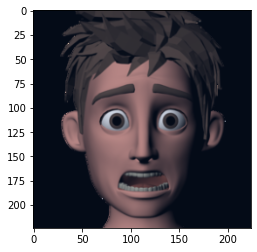

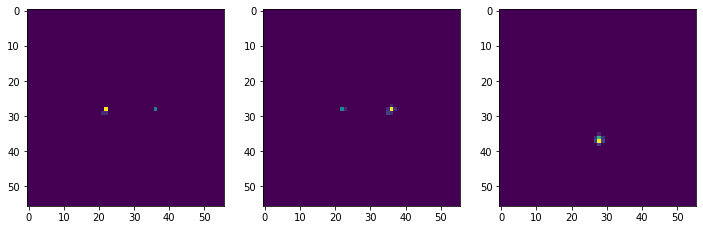

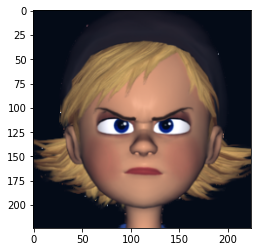

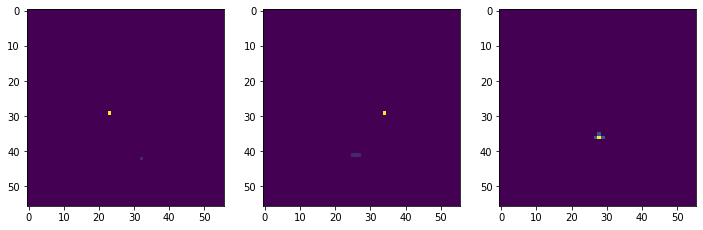

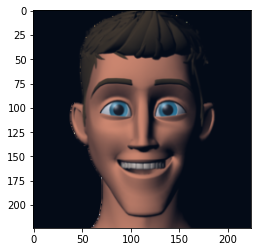

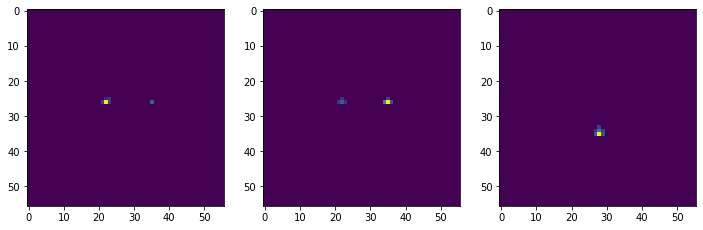

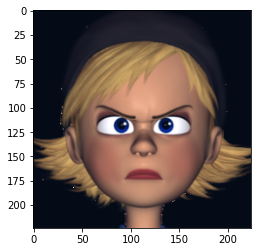

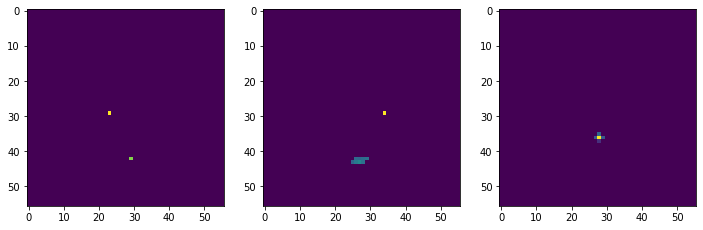

In [27]:
for i in range(len(activity_maps)):
    print("i", i)
    display_FR_lmk(train_data[0][i], max_pool_activities[i], activity_maps[i])
    print()

## compute positions

In [215]:
def get_lmk(preds, patch_size=8, verbose=False):
    # compute fr lmk activity
    lmks = []
    max_values = []
    for pred in preds:
        lmk_pos = []
        max_val = []
        for act_map in pred:  # loop for each landmarks
            patches = pred_to_patch(act_map, patch_size=patch_size)
            lmk, max_value = get_patches_centers(patches, patch_size=patch_size)
            lmk_pos.append(lmk)
            max_val.append(max_value)
        lmks.append(lmk_pos)
        max_values.append(max_val)

        if verbose:
            for j in range(len(lmks)):
                print("[LMK] {}) {}".format(j, lmks[j]))
            print()

    return lmks, max_values

In [29]:
lmks_poses, max_values = get_lmk(max_pool_activities)
print("len lmks_poses", len(lmks_poses))
print("shape max_values", np.shape(max_values))

shape preds (5, 3, 56, 56)
len lmks_poses 5
shape max_values (5, 3)


/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


In [213]:
def transform_pos_to_dict(lmk_pos, max_values, lmk_type=None):
    pos_list = []
    for i, img_poses in enumerate(lmk_pos):  # image dimensions
        pos_dict = {}
        n_entry = 0
        for l, lmks in enumerate(img_poses):
            for p, pos in enumerate(lmks):
                if lmk_type is None:
                    pos_dict[n_entry] = {'type': l, 'pos': pos, 'max': max_values[i][l][p]}
                else:
                    pos_dict[n_entry] = {'type': lmk_type, 'pos': pos, 'max': max_values[i][l][p]}
                n_entry += 1
        pos_list.append(pos_dict)

    return pos_list

In [31]:
lmks_poses_dict = transform_pos_to_dict(lmks_poses, max_values)
max_pool_activities_dict = []
for l_pos in lmks_poses_dict:
    max_spacial_activities = max_pool_patches_activity(l_pos)
    max_pool_activities_dict.append(max_spacial_activities)

for image_activities in max_pool_activities_dict:
    for a in image_activities:
        print(image_activities[a])
    print()

{'type': 0, 'pos': [20.89026883542564, 28.03226450509073], 'max': 1.0}
{'type': 0, 'pos': [32.482605756243665, 41.42464642793435], 'max': 0.14554831457942746}
{'type': 1, 'pos': [35.92130580138903, 28.075292315987443], 'max': 1.0}
{'type': 1, 'pos': [27.48281093752417, 41.093051533050605], 'max': 0.15178792987792886}
{'type': 2, 'pos': [28.049190378424978, 35.61671201938131], 'max': 1.0}
{'type': 2, 'pos': [28.504420413469667, 48.99996927725214], 'max': 0.1051037870509462}

{'type': 0, 'pos': [21.909365031218815, 28.189658884749168], 'max': 1.0}
{'type': 1, 'pos': [35.89083867759919, 28.13116019013095], 'max': 1.0}
{'type': 2, 'pos': [28.009279777662073, 36.6322154690549], 'max': 1.0}

{'type': 0, 'pos': [22.999955200286717, 28.999968000204795], 'max': 1.0}
{'type': 0, 'pos': [32.0, 41.99987281123619], 'max': 0.10063142064130791}
{'type': 1, 'pos': [33.99998720008192, 28.999968000204795], 'max': 1.0}
{'type': 1, 'pos': [25.999704557190793, 40.99997951139131], 'max': 0.11011551913274348

In [200]:
def transform_lmk_dict_to_plotting_pos(dict, min_lmk=10, max_lmk=10, ratio=1):
    lmks_pos = {}

    for i, image_dict in enumerate(dict):
        pos_array = []
        if len(image_dict) > max_lmk:
            print("lmk detection found more landmarks than the max_value ({}) in image: {}".format(max_lmk, i))

        if len(image_dict) < min_lmk:
            print("lmk detection found less landmarks than the min_value ({}) in image: {}".format(min_lmk, i))

        for l in image_dict:
            pos = image_dict[l]['pos']
            pos = np.round(np.array(pos) * ratio).astype(int)
            pos_array.append(pos)
        lmks_pos[i] = np.array(pos_array)

    return lmks_pos

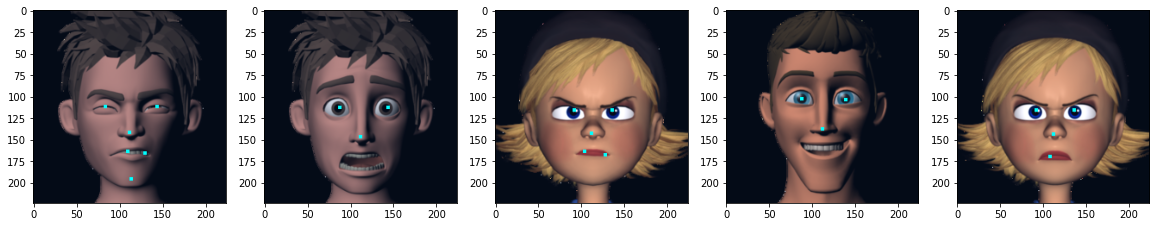

In [33]:
lmk_pos_plotting = transform_lmk_dict_to_plotting_pos(max_pool_activities_dict, ratio=224/56)
display_images(train_data[0][:5], lmks=lmk_pos_plotting, pre_processing='VGG19')

# Facial Expression Recognition pipeline

In [34]:
# fer_sigmas = np.ones(np.shape(FER_patterns)[1]) * 1000
# fer_sigmas = np.array([3000, 5000, 5000, 4000, 4000, 6000, 3000, 5000, 6000, 6000])
# fer_sigmas = np.array([3700, 5100, 5300, 4300, 4300, 6900, 4000, 5200, 6400, 6300])
#
# # compute activity maps
# fer_activity_maps = optimize_sigmas_by_detection(train_FER_preds[:100], FER_patterns, lr_rate=100, sigmas=fer_sigmas)

In [35]:
# fer_sigmas = np.array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000])
fer_sigmas = np.array([2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000, 2000])
# fer_sigmas = np.array([3700, 5100, 5300, 4300, 4300, 6900, 4000, 5200, 6400, 6300])  # (7, 7)
fer_activity_maps = compute_activity_maps(train_FER_preds[:14], FER_patterns, sigmas=fer_sigmas)

# max pool activity
fer_max_pool_activities = np.amax(fer_activity_maps, axis=1)
fer_argmax_pool_activities = np.argmax(fer_activity_maps, axis=1)
print("shape fer_max_pool_activities", np.shape(fer_max_pool_activities))
print("shape fer_argmax_pool_activities", np.shape(fer_argmax_pool_activities))
print("min max fer_max_pool_activities")
print(np.amin(fer_max_pool_activities, axis=(1, 2 ,3)))
print(np.amax(fer_max_pool_activities, axis=(1, 2, 3)))

# threshold activity to remove small noise
fer_max_pool_activities[fer_max_pool_activities < 0.1] = 0.0

# get lmks
fer_lmks_poses, fer_max_values = get_lmk(fer_max_pool_activities)
print("len fer_lmks_poses", len(fer_lmks_poses))
print("shape fer_max_values", np.shape(fer_max_values))

# apply spatial pooling
fer_lmks_poses_dict = transform_pos_to_dict(fer_lmks_poses, fer_max_values)
fer_max_pool_activities_dict = []
for l_pos in fer_lmks_poses_dict:
    max_spacial_activities = max_pool_patches_activity(l_pos, dist_threshold=1, verbose=False)
    fer_max_pool_activities_dict.append(max_spacial_activities)

shape fer_max_pool_activities (14, 10, 56, 56)
shape fer_argmax_pool_activities (14, 10, 56, 56)
min max fer_max_pool_activities
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1.    1.    1.    1.    0.201 1.    1.    1.    0.344 1.    1.    0.127 0.32  1.   ]
shape preds (14, 10, 56, 56)
len fer_lmks_poses 14
shape fer_max_values (14, 10)


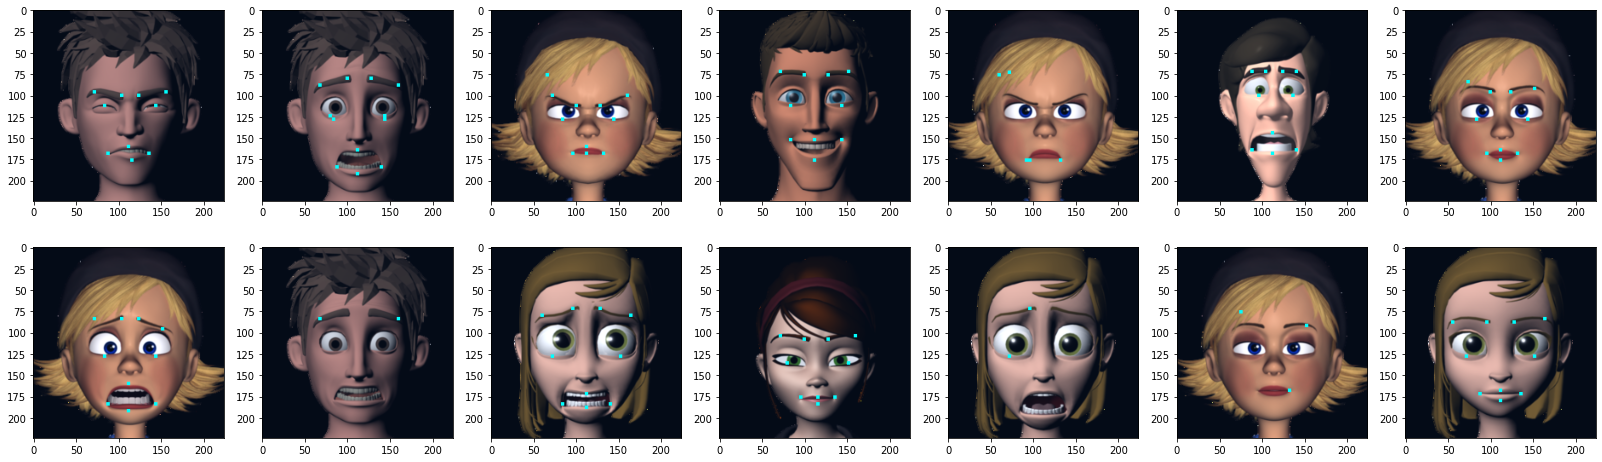

In [36]:
fer_lmk_pos_plotting = transform_lmk_dict_to_plotting_pos(fer_max_pool_activities_dict, ratio=224/56)
display_images(train_data[0][:14], lmks=fer_lmk_pos_plotting, pre_processing='VGG19')

## Test only with Ray but multiple image for each landmarks

In [269]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

In [281]:
def optimize_by_landmarks_count(preds, patterns, lmk_idx=None, lr_rate=100, batch_size=16, sigmas=None):

    activities_dict = []

    if lmk_idx is None:
        lmk_indexes = range(np.shape(patterns)[1])
    else:
        lmk_indexes = lmk_idx

    opt_sigmas = []
    for l in tqdm.tqdm(lmk_indexes):

        do_continue = True

        if sigmas is not None:
            sigma = sigmas[l]
        else:
            sigma = lr_rate

        memory_max_pool_activity = []  # allows to save the previous step
        memory_sigma = sigma  # allows to save the previous step
        while do_continue:
            # predict lmk positions
            activity_maps = np.array([])
            for x in batch(range(np.shape(preds)[0]), batch_size):
                act_maps = compute_activity_maps(preds[x], patterns, sigmas=sigma, lmk_idx=[l], disable_tqdm=True)
                if len(np.shape(activity_maps)) == 1:
                    activity_maps = act_maps
                else:
                    activity_maps = np.concatenate((activity_maps, act_maps), axis=0)
            max_pool_activities = np.amax(activity_maps, axis=1)
            max_pool_activities[max_pool_activities < 0.1] = 0.0
            lmks_poses, max_values = get_lmk(max_pool_activities, patch_size=14)

            lmks_poses_dict = transform_pos_to_dict(lmks_poses, max_values, lmk_type=l)
            max_pool_activities_dict = []
            for lmk_pos in lmks_poses_dict:
                max_spacial_activities = max_pool_patches_activity(lmk_pos, dist_threshold=1.5, verbose=False)
                max_pool_activities_dict.append(max_spacial_activities)

            # compute number of lmk found to continue training
            min_lmk_per_image = 1000
            max_lmk_per_image = 0
            # check if more than one lmk per image
            for  i in range(np.shape(preds)[0]):
                n_lmk = len(max_pool_activities_dict[i])

                if n_lmk < min_lmk_per_image:
                    min_lmk_per_image = n_lmk
                if n_lmk > max_lmk_per_image:
                    max_lmk_per_image = n_lmk

            if min_lmk_per_image <= 1 and max_lmk_per_image < 2:
                memory_sigma = sigma
                sigma += lr_rate
                memory_max_pool_activity = max_pool_activities_dict
            else:
                do_continue = False

        if len(memory_max_pool_activity) == 0:
            memory_max_pool_activity = max_pool_activities_dict
            print("[WARNING] activities_map_dict might use non-optimized parameters for lmk: {}!".format(l))

        opt_sigmas.append(memory_sigma)
        activities_dict.append(memory_max_pool_activity)

    # transform activites dict to match order of (n_images, n_lmk, n_pos, 2)
    activities_map_dict = []
    for i in range(len(preds)):
        dict = {}
        for l in range(len(activities_dict)):
            if len(activities_dict[l][i]) != 0:
                dict[l] = activities_dict[l][i][0]
        activities_map_dict.append(dict)

    print("---------------------------------")
    print("Finish optimizing sigmas")
    print(opt_sigmas)
    print("---------------------------------")
    print("---------------------------------")
    print()
    return activities_map_dict, opt_sigmas

In [267]:
# test only on ray (fixed pipeline)
# get only ray images (2 of each cat)
# ray_idx = np.array([21, 37, 43, 124, 38, 67, 15, 22, 55, 130, 1, 8, 0, 26])  # two expression each
ray_idx = np.array([ 21,  43,  38,  15,  55,   1,   0,
                     37, 124,  67,  22, 130,   8,  26,
                     49, 166,  76,  47, 139,  51,  71,
                     73, 212,  89, 146, 160,  62,  75,
                     84, 294,  99, 227, 189,  72,  92,
                    145, 328, 123, 420, 219, 105, 142,
                    148, 504, 151, 468, 248, 164, 147,
                    150, 574, 158, 559, 401, 186, 185])  # three expression each
print("shape ray_idx", np.shape(ray_idx))
ray_rel_idx = np.expand_dims(np.arange(49), axis=(0, 2))  # one expression each relative to ray_idx
ray_lmk_idx = np.expand_dims(ray_idx[:-7], axis=(0, 2))  # two expression each of ray_idx
ray_training_data = [train_data[0][ray_idx], train_data[1][ray_idx]]
print("shape ray_training_data", np.shape(ray_training_data[0]))
# predict images
ray_training_FR_preds, ray_training_FER_preds = predict_v4(ray_training_data)
print("shape ray_training_FR_preds", np.shape(ray_training_FR_preds))
print("shape ray_training_FER_preds", np.shape(ray_training_FER_preds))
# build patterns only for ray
train_FER_ray_lmk_preds = ray_training_FER_preds[np.reshape(ray_rel_idx, -1)]
print("shape train_FER_ray_lmk_preds", np.shape(train_FER_ray_lmk_preds))
posX = np.round(86 / 4).astype(int)
posY = np.round(114 / 4).astype(int)
# get pos for each training pattern
print("len lmk_pos", len(lmk_pos))
print("shape lmk_pos[0]", np.shape(lmk_pos[0]))
print("shape ray_lmk_idx", np.shape(ray_lmk_idx))
filt_ray_lmk_pos = filter_lmk_pos(lmk_pos, ray_lmk_idx)
print("filt_ray_lmk_pos (n_patterns, n_lmks, pos)", np.shape(filt_ray_lmk_pos))

shape ray_idx (56,)
shape ray_training_data (56, 224, 224, 3)


100%|██████████| 56/56 [00:01<00:00, 30.74it/s]


[predict_v4] shape prediction (56, 56, 56, 256)
[predict_v4] shape eyes semantic feature selection (56, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (56, 56, 56, 61)
[predict_v4] shape fr_preds (56, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (56, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (56, 56, 56, 16)
[predict_v4] shape fer_preds (56, 56, 56, 18)
shape ray_training_FR_preds (56, 56, 56, 68)
shape ray_training_FER_preds (56, 56, 56, 18)
shape train_FER_ray_lmk_preds (49, 56, 56, 18)
len lmk_pos 127
shape lmk_pos[0] (1, 13, 2)
shape ray_lmk_idx (1, 49, 1)
filt_ray_lmk_pos (n_patterns, n_lmks, pos) (49, 13, 2)


shape FER_ray_patterns (49, 10, 5, 5, 18)


100%|██████████| 10/10 [02:51<00:00, 17.13s/it]


---------------------------------
Finish optimizing sigmas
[2500, 3100, 2500, 2200, 1500, 2700, 1500, 1800, 2200, 2000]
---------------------------------
---------------------------------

lmk detection found less landmarks than the min_value (10) in image: 51
lmk detection found less landmarks than the min_value (10) in image: 52
lmk detection found less landmarks than the min_value (10) in image: 53
lmk detection found less landmarks than the min_value (10) in image: 54
lmk detection found less landmarks than the min_value (10) in image: 55
fer_ray_lmk_pos ()


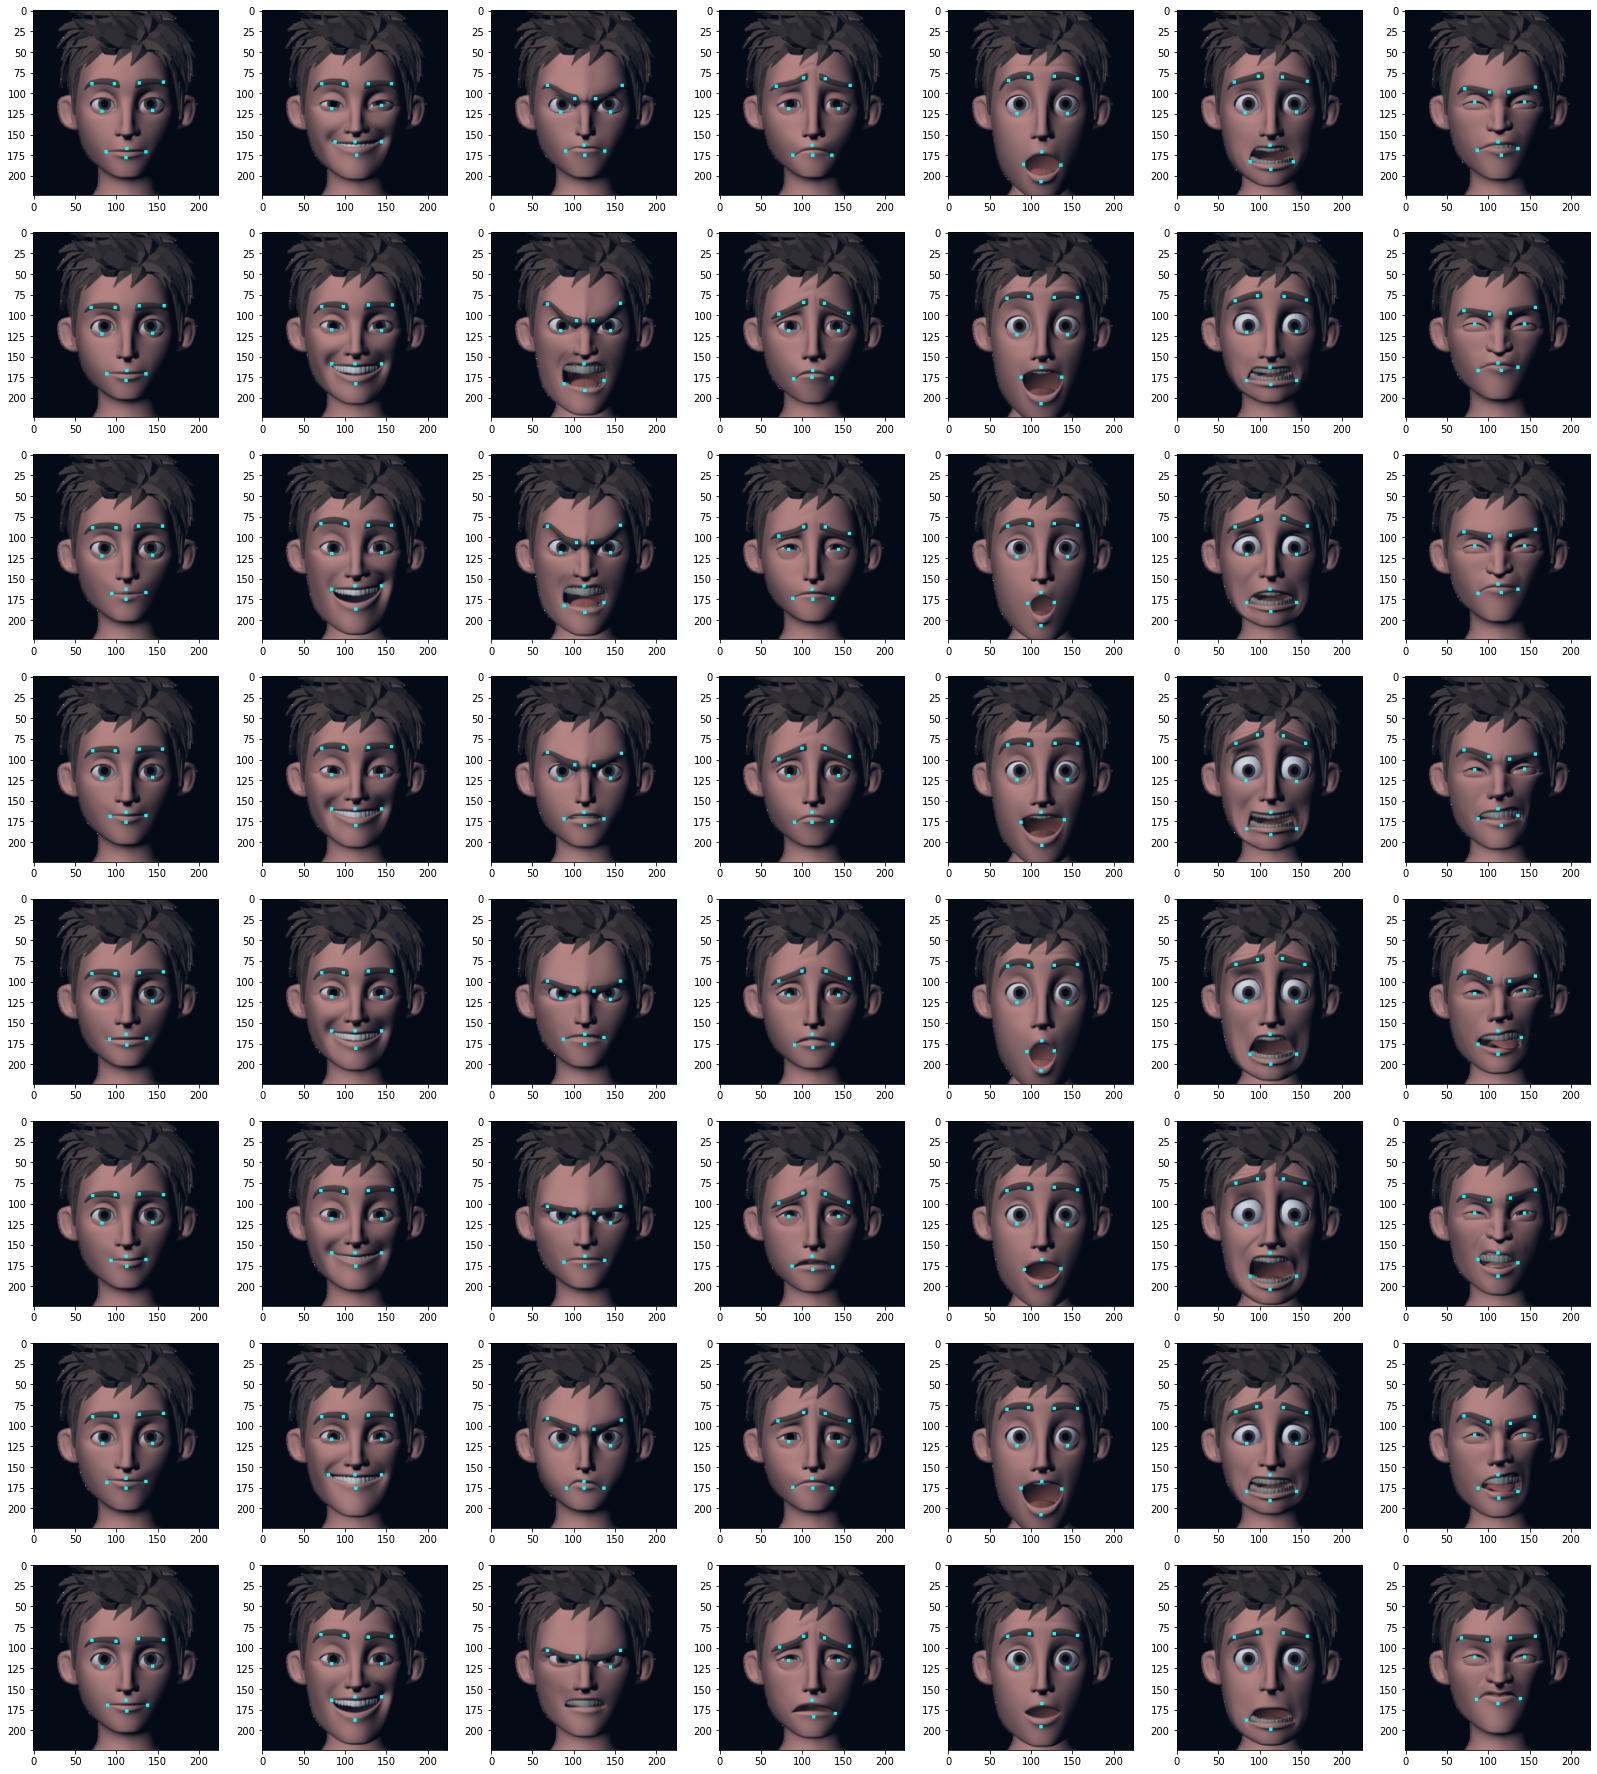

In [300]:
# test only on ray (test pipeline)
batch_size = 16
lmk_idx_to_optimize = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# FER_ray_patterns = construct_patterns(train_FER_ray_lmk_preds, filt_ray_lmk_pos[:, 3:], (7, 7), ratio=224/56)
FER_ray_patterns = construct_patterns(train_FER_ray_lmk_preds, filt_ray_lmk_pos[:, 3:], (5, 5), ratio=224/56)
print("shape FER_ray_patterns", np.shape(FER_ray_patterns))
# fer_ray_sigmas = np.array([100, 100, 100, 100, 100, 100, 100, 100, 100, 100])
fer_ray_sigmas = np.array([2500, 3100, 2500, 2200, 1500, 2700, 1500, 1800, 2200, 2000])  # (5, 5)
# fer_ray_sigmas = np.array([3500, 3600, 3000, 3200, 2000, 4800, 2500, 3100, 3800, 2800])  # (7, 7)
# fer_ray_sigmas = np.array([100, 100, 100, 100, 2500, 100, 100, 100, 100, 100])  # (7, 7)

fer_ray_max_pool_activities_dict, fer_ray_sigmas = optimize_by_landmarks_count(ray_training_FER_preds, FER_ray_patterns, sigmas=fer_ray_sigmas, batch_size=batch_size, lmk_idx=lmk_idx_to_optimize)

# plot
fer_ray_lmk_pos = transform_lmk_dict_to_plotting_pos(fer_ray_max_pool_activities_dict, min_lmk=len(lmk_idx_to_optimize), ratio=224/56)
display_images(ray_training_data[0], lmks=fer_ray_lmk_pos, pre_processing='VGG19')

## Train Norm-reference encoding

In [467]:
# learn neutral pattern
ref_idx = [0]
# ref_idx = [0, 7, 14, 21, 28, 35]
ref_frames = [fer_ray_max_pool_activities_dict[i] for i in ref_idx]
print("len(ref_frames)", len(ref_frames))
ref_vector = []
for frame in ref_frames:  # loop over images
    frame_pos = []
    for l in frame:  # loop over lmk
        # control that the lmk are in correct order
        if frame[l]['type'] == l:
            frame_pos.append(frame[l]['pos'])
        else:
            print("issue with lmk: {}, expected type {}, received {}".format(l, l, frame[l]['type']))
    ref_vector.append(frame_pos)
ref_vector = np.array(ref_vector)
ref_vector = np.mean(ref_vector, axis=0)
print("shape ref_vector", np.shape(ref_vector))

len(ref_frames) 1
shape ref_vector (10, 2)


In [468]:
# learn tuning directions
tuning_idx = [0, 1, 30, 3, 4, 5, 6]
# tuning_idx = [0, 1, 30, 3, 4, 5, 6, 9, 11, 33, 41, 25]
matching_category_list = [[7, 2], [8, 4], [9, 5], [10, 6], [11, 4]]
tuning_frames = [fer_ray_max_pool_activities_dict[i] for i in tuning_idx]
print("len(tuning_frames)", len(tuning_frames))
tun_vector = []
for frame in tuning_frames:  # loop over images
    frame_pos = []
    for l in frame:  # loop over lmk
        # control that the lmk are in correct order
        if frame[l]['type'] == l:
            frame_pos.append(frame[l]['pos'])
        else:
            print("issue with lmk: {}, expected type {}, received {}".format(l, l, frame[l]['type']))
    tun_vector.append(frame_pos)
tun_vector = np.array(tun_vector) - ref_vector
print("shape tun_vector", np.shape(tun_vector))

len(tuning_frames) 7
shape tun_vector (7, 10, 2)


In [470]:
def compute_accuracy(preds, labels):
    n_correct = 0
    n_total = len(labels)

    for i in range(n_total):
        if preds[i] == labels[i]:
            n_correct +=1

    return n_correct/n_total

In [446]:
def convert_dict_to_pos(dict, ref_frame, n_lmk=10):
    input = np.zeros((len(dict), n_lmk, 2))
    for f, frame in enumerate(dict):
        for l in range(n_lmk):
            if frame.get(l) is not None:
                input[f, frame[l]['type']] = frame[l]['pos']
            else:
                input[f, l] = ref_frame[l]

    return input

In [447]:
def compute_projections(input, ref_vector, tun_vectors, nu=1, verbose=False, neutral_threshold=5, matching_cat=None):
    projections = []

    # normalize by norm of each landmarks
    norm_t = np.linalg.norm(tun_vectors, axis=2)

    # for each images
    for i in range(len(input)):
        # compute relative vector (difference)
        diff = input[i] - ref_vector
        proj = []
        # for each category
        for j in range(len(tun_vectors)):
            proj_length = 0
            # for each landmarks
            for k in range(len(ref_vector)):
                if norm_t[j, k] != 0.0:
                    f = np.dot(diff[k], tun_vectors[j, k]) / norm_t[j, k]
                    f = np.power(f, nu)
                else:
                    f = 0
                proj_length += f
            # ReLu activation
            if proj_length < 0:
                proj_length = 0
            proj.append(proj_length)
        projections.append(proj)

    projections = np.array(projections)
    # apply neutral threshold
    projections[projections < neutral_threshold] = 0

    if verbose:
        print("projections", np.shape(projections))
        print(projections)
        print()
        print("max_projections", np.shape(np.amax(projections, axis=1)))
        print(np.amax(projections, axis=1))

    proj_pred = np.argmax(projections, axis=1)

    if matching_cat is not None:
        for match in matching_cat:
           proj_pred[proj_pred == match[0]] = match[1]

    return proj_pred

In [474]:
ray_input = convert_dict_to_pos(fer_ray_max_pool_activities_dict, ref_vector, n_lmk=len(ref_vector))
print("shape input", np.shape(ray_input))
print("shape ref_vector", np.shape(ref_vector))
print("shape tun_vector", np.shape(tun_vector))
ray_projections_preds = compute_projections(ray_input, ref_vector, tun_vector, matching_cat=matching_category_list, neutral_threshold=5, verbose=False)
print("num images (len ray_projections_preds):", len(ray_projections_preds))
# print(ray_projections_preds)
print("accuracy", compute_accuracy(ray_projections_preds, ray_training_data[1]))

shape input (56, 10, 2)
shape ref_vector (10, 2)
shape tun_vector (7, 10, 2)
num images (len ray_projections_preds): 56
accuracy 0.9107142857142857


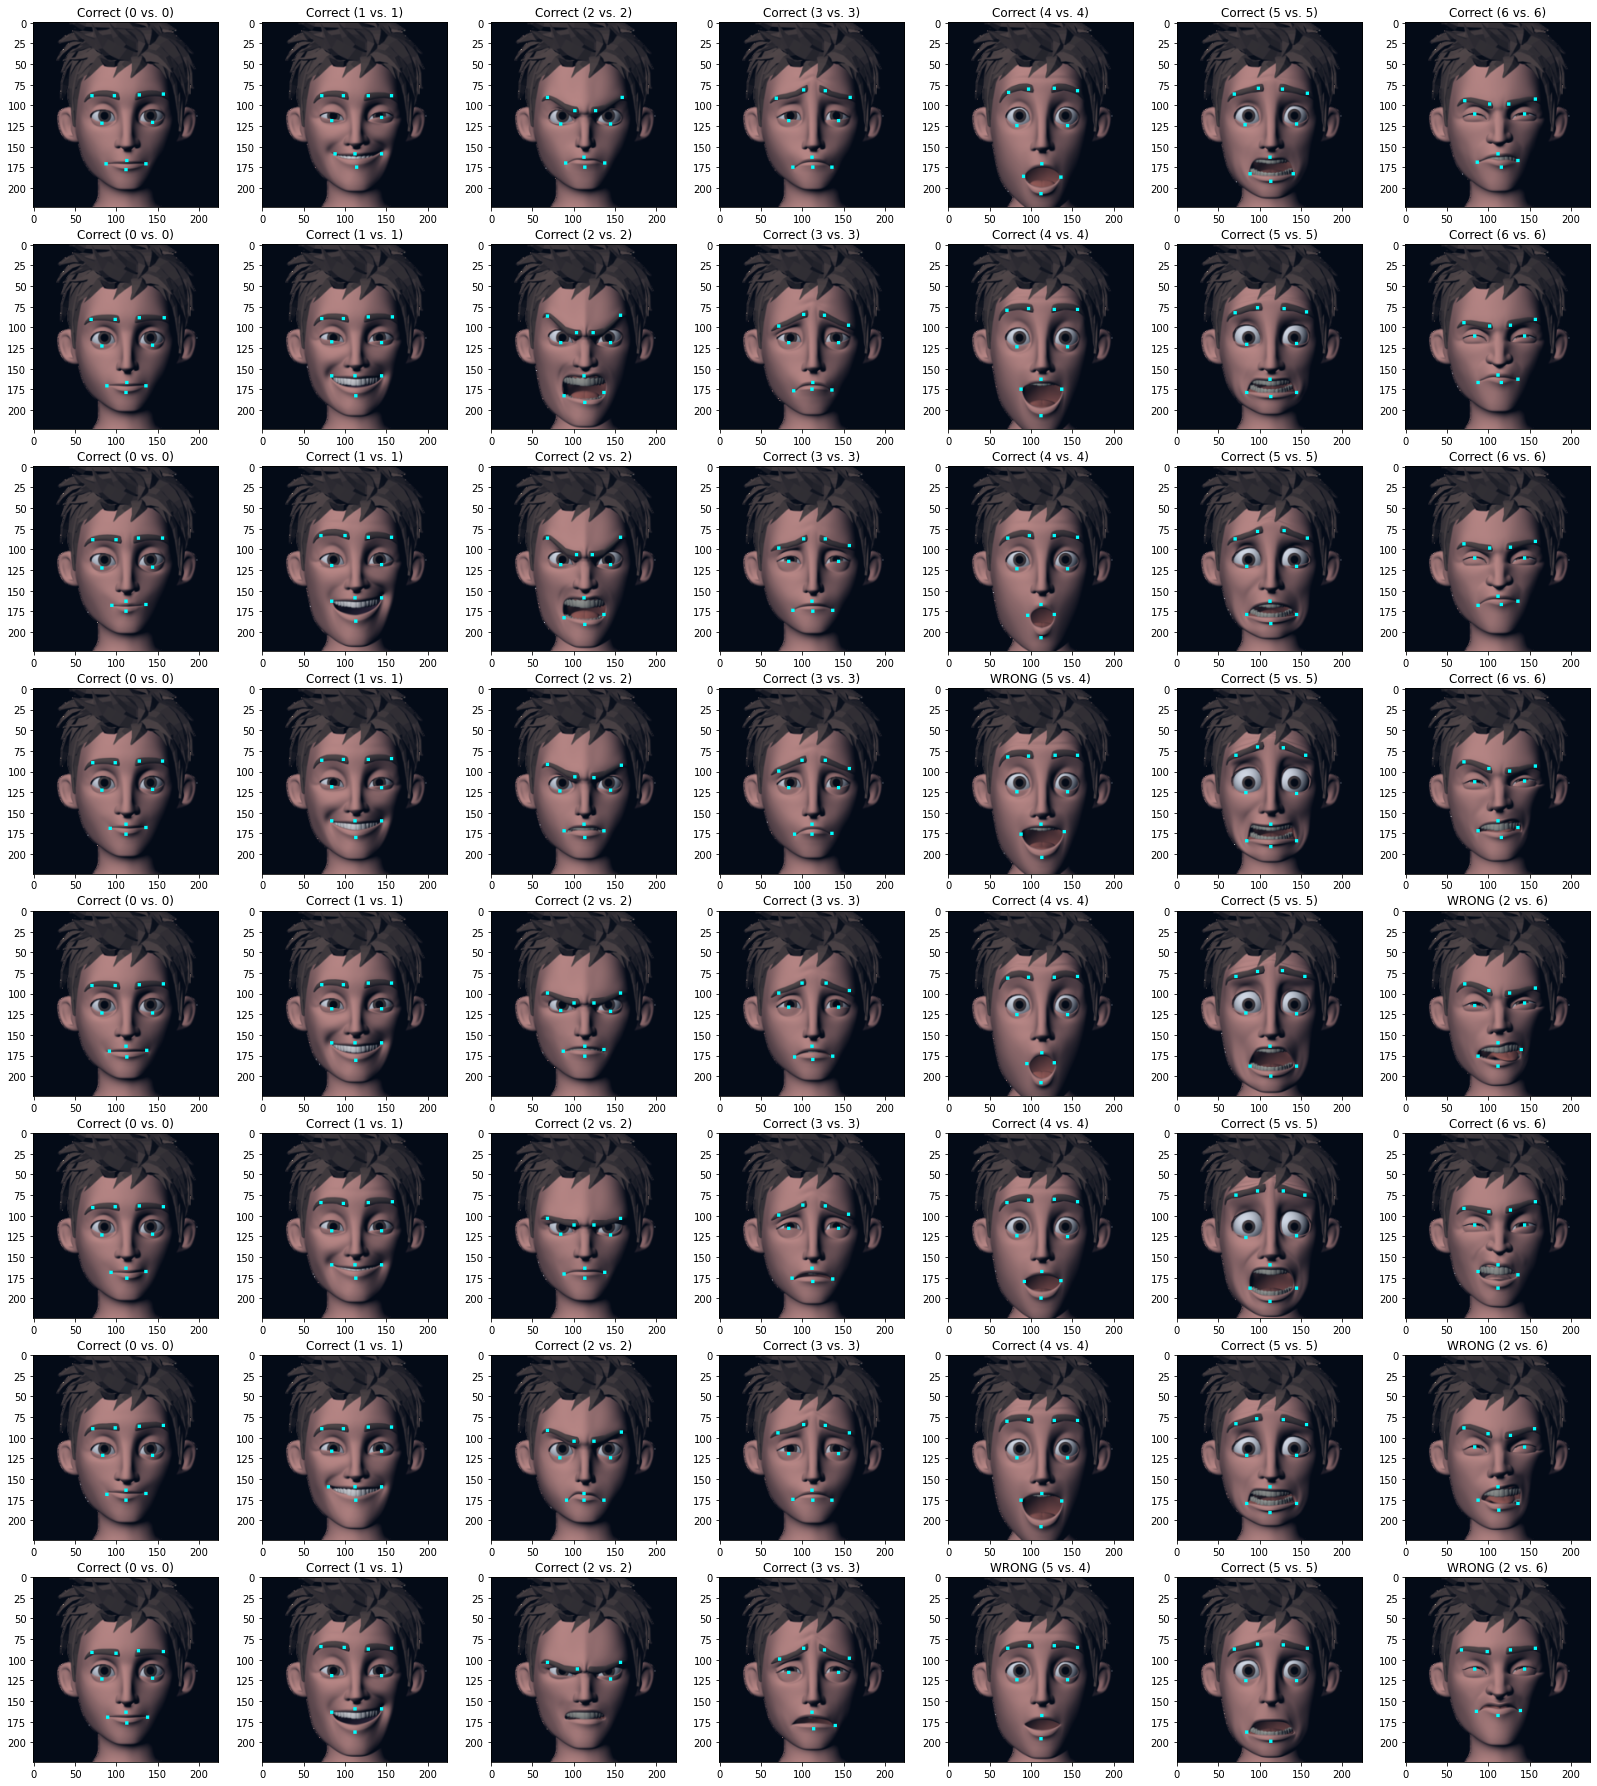

In [441]:
titles = []
for i, pred in enumerate(ray_projections_preds):
    if pred == ray_training_data[1][i]:
        titles.append("Correct ({} vs. {})".format(pred, int(ray_training_data[1][i])))
    else:
        titles.append("WRONG ({} vs. {})".format(pred, int(ray_training_data[1][i])))
display_images(ray_training_data[0], lmks=fer_ray_lmk_pos, pre_processing='VGG19', titles=titles)

# TEST

### load data

In [39]:
test_data = load_data(config, train=False)
print("shape test_data[0]", np.shape(test_data[0]))

100%|██████████| 6000/6000 [00:13<00:00, 434.20it/s]


shape test_data[0] (6000, 224, 224, 3)


In [479]:
# predict images
idx = [2, 11, 13, 23, 26, 32, 37, 45, 46, 62, 67, 72, 73, 75]
print("length idx", len(idx))
ray_test_data = [test_data[0][idx], test_data[1][idx]]
test_FR_preds, test_FER_preds = predict_v4(ray_test_data)
print("shape test_FR_preds", np.shape(test_FR_preds))
print("shape test_FER_preds", np.shape(test_FER_preds))

length idx 14


100%|██████████| 14/14 [00:00<00:00, 28.09it/s]


[predict_v4] shape prediction (14, 56, 56, 256)
[predict_v4] shape eyes semantic feature selection (14, 56, 56, 7)
[predict_v4] shape nose semantic feature selection (14, 56, 56, 61)
[predict_v4] shape fr_preds (14, 56, 56, 68)

[predict_v4] shape eyebrow semantic feature selection (14, 56, 56, 2)
[predict_v4] shape lips semantic feature selection (14, 56, 56, 16)
[predict_v4] shape fer_preds (14, 56, 56, 18)
shape test_FR_preds (14, 56, 56, 68)
shape test_FER_preds (14, 56, 56, 18)


10it [00:23,  2.32s/it]
/Users/michaelstettler/miniforge3/envs/env_tf/lib/python3.10/site-packages/numpy/core/fromnumeric.py:2007: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


shape fer_act_maps (14, 49, 10, 56, 56)
shape fer_test_activity_maps (14, 49, 10, 56, 56)
shape fer_test_max_pool_activities (14, 10, 56, 56)
shape fer_test_lmks_poses (14, 10)


100%|██████████| 14/14 [00:00<00:00, 5390.64it/s]


lmk detection found less landmarks than the min_value (10) in image: 1
lmk detection found less landmarks than the min_value (10) in image: 4
lmk detection found less landmarks than the min_value (10) in image: 5
lmk detection found less landmarks than the min_value (10) in image: 10
lmk detection found less landmarks than the min_value (10) in image: 11


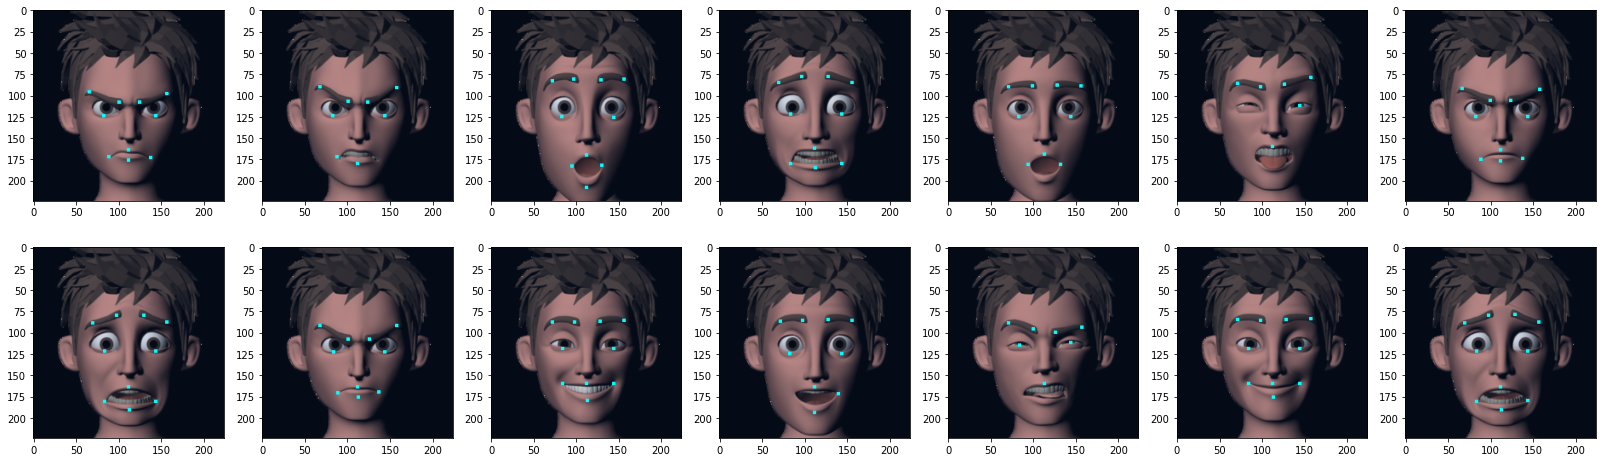

In [282]:
# predict lmk positions
batch_size = 16

fer_test_activity_maps = np.array([])
for x in batch(range(np.shape(test_FER_preds)[0]), batch_size):
    fer_act_maps = compute_activity_maps(test_FER_preds[x], FER_ray_patterns, sigmas=fer_ray_sigmas)
    print("shape fer_act_maps", np.shape(fer_act_maps))
    if len(np.shape(fer_test_activity_maps)) == 1:
        fer_test_activity_maps = fer_act_maps
    else:
        fer_test_activity_maps = np.concatenate((fer_test_activity_maps, fer_act_maps), axis=0)
print("shape fer_test_activity_maps", np.shape(fer_test_activity_maps))

fer_test_max_pool_activities = np.amax(fer_test_activity_maps, axis=1)
fer_test_max_pool_activities[fer_test_max_pool_activities < 0.1] = 0.0
print("shape fer_test_max_pool_activities", np.shape(fer_test_max_pool_activities))

fer_test_lmks_poses, fer_test_max_values = get_lmk(fer_test_max_pool_activities, patch_size=14)
print("shape fer_test_lmks_poses", np.shape(fer_test_lmks_poses))
fer_test_lmks_poses_dict = transform_pos_to_dict(fer_test_lmks_poses, fer_test_max_values)
fer_test_max_pool_activities_dict = []
for l_pos in tqdm.tqdm(fer_test_lmks_poses_dict):
    max_spacial_activities = max_pool_patches_activity(l_pos, dist_threshold=2, verbose=False)
    fer_test_max_pool_activities_dict.append(max_spacial_activities)

# plot
fer_test_lmk_pos_plotting = transform_lmk_dict_to_plotting_pos(fer_test_max_pool_activities_dict, ratio=224/56)
display_images(ray_test_data[0], lmks=fer_test_lmk_pos_plotting, pre_processing='VGG19')

In [480]:
ray_input = convert_dict_to_pos(fer_test_max_pool_activities_dict, ref_vector, n_lmk=len(ref_vector))
print("shape input", np.shape(ray_input))
print("shape ref_vector", np.shape(ref_vector))
print("shape tun_vector", np.shape(tun_vector))
ray_projections_preds = compute_projections(ray_input, ref_vector, tun_vector, matching_cat=matching_category_list, neutral_threshold=5, verbose=False)
print("shape ray_projections_preds", np.shape(ray_projections_preds))
print(ray_projections_preds)
print("accuracy", compute_accuracy(ray_projections_preds, ray_test_data[1]))

shape input (14, 10, 2)
shape ref_vector (10, 2)
shape tun_vector (7, 10, 2)
shape ray_projections_preds (14,)
[2 2 4 5 3 2 2 5 2 1 6 2 1 5]
accuracy 0.7142857142857143


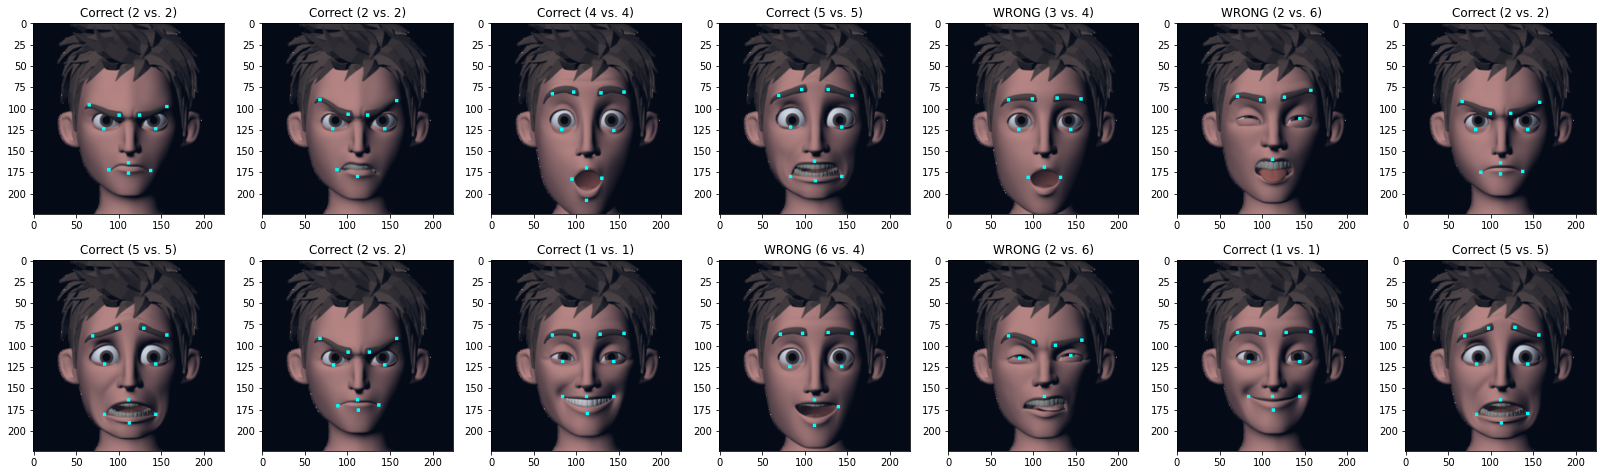

In [482]:
titles = []
for i, pred in enumerate(ray_projections_preds):
    if pred == ray_test_data[1][i]:
        titles.append("Correct ({} vs. {})".format(pred, int(ray_test_data[1][i])))
    else:
        titles.append("WRONG ({} vs. {})".format(pred, int(ray_test_data[1][i])))
display_images(ray_test_data[0], lmks=fer_test_lmk_pos_plotting, pre_processing='VGG19', titles=titles)